In [1]:
import xgboost as xgb
from catboost import CatBoostClassifier, cv ,Pool
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer,KNNImputer
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif, SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it

# Download data

In [2]:
data = pd.read_csv('./data/orange_small_churn_train_data.csv')

In [3]:
data.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Columns: 232 entries, ID to labels
dtypes: float64(192), int64(2), object(38)
memory usage: 32.4+ MB


In [5]:
# check null in features
dict_nan = {name: np.sum(data[name].isnull()) for name in data.columns}
dict_nan

{'ID': 0,
 'Var1': 18038,
 'Var2': 17831,
 'Var3': 17832,
 'Var4': 17736,
 'Var5': 17799,
 'Var6': 1991,
 'Var7': 1976,
 'Var8': 18299,
 'Var9': 18038,
 'Var10': 17799,
 'Var11': 17832,
 'Var12': 18085,
 'Var13': 1976,
 'Var14': 17832,
 'Var15': 18299,
 'Var16': 17799,
 'Var17': 17736,
 'Var18': 17736,
 'Var19': 17736,
 'Var20': 18299,
 'Var21': 1991,
 'Var22': 1792,
 'Var23': 17799,
 'Var24': 2616,
 'Var25': 1792,
 'Var26': 17799,
 'Var27': 17799,
 'Var28': 1793,
 'Var29': 18038,
 'Var30': 18038,
 'Var31': 18299,
 'Var32': 18299,
 'Var33': 18010,
 'Var34': 17831,
 'Var35': 1792,
 'Var36': 17831,
 'Var37': 17736,
 'Var38': 1792,
 'Var39': 18299,
 'Var40': 17831,
 'Var41': 18038,
 'Var42': 18299,
 'Var43': 17831,
 'Var44': 1792,
 'Var45': 18171,
 'Var46': 17831,
 'Var47': 18038,
 'Var48': 18299,
 'Var49': 17831,
 'Var50': 18038,
 'Var51': 16888,
 'Var52': 18299,
 'Var53': 18038,
 'Var54': 17831,
 'Var55': 18299,
 'Var56': 18055,
 'Var57': 0,
 'Var58': 18038,
 'Var59': 17990,
 'Var60': 1

In [6]:
# check disbalance in classes
print(data['labels'].value_counts())
print(data['labels'].unique())

-1.0    16921
 1.0     1377
Name: labels, dtype: int64
[-1.  1. nan]


In [7]:
data['labels'].replace(-1, 0, inplace=True)
data.dropna(subset=['labels'], inplace=True)
labels = data['labels']
data = data.iloc[:,:-1]

methods simple feature selection

1. Drop feature with nans more half of data done
2. Calc corr between feature and drop with high corr
3. drop almost constat feature done

Compare methods:

1. use mutual info for cat feature done
2. binary classification done
3. corr between cat feature and labels done
4. interative algo done
5. method is based on models



# Simple preprocessing feature

In [8]:
# drop feture with null more half of dataset
def check_feat_without(data, columns, threshold = 0):
    flag_nan_col = [np.sum(data[name].isnull()) < threshold for name in columns]
    return columns[flag_nan_col]
    

In [9]:
numeric_col = data.columns[1:190]
cat_col = data.columns[190:]
print(len(numeric_col))
print(len(cat_col))

189
41


In [10]:
right_numeric_column = check_feat_without(data, numeric_col, threshold = len(data)//2)
right_cat_column = check_feat_without(data, cat_col, threshold = len(data)//2)
print(len(right_numeric_column))
print(len(right_cat_column))

41
28


In [11]:
# check unique in cat feat
for cur_cat in right_cat_column:
    count_uniq = len(data[cur_cat].unique())
    print(f'{cur_cat}: {count_uniq}')

Var192: 326
Var193: 44
Var195: 21
Var196: 4
Var197: 207
Var198: 2721
Var199: 2639
Var202: 4673
Var203: 4
Var204: 100
Var205: 4
Var206: 22
Var207: 12
Var208: 3
Var210: 6
Var211: 2
Var212: 71
Var216: 1247
Var217: 7944
Var218: 3
Var219: 20
Var220: 2721
Var221: 7
Var222: 2721
Var223: 5
Var226: 23
Var227: 7
Var228: 29


In [12]:
# check unique in num feat
for cur_num in right_numeric_column:
    count_uniq = len(data[cur_num].unique())
    print(f'{cur_num}: {count_uniq}')

Var6: 1039
Var7: 7
Var13: 1877
Var21: 498
Var22: 498
Var24: 63
Var25: 190
Var28: 2513
Var35: 10
Var38: 11908
Var44: 6
Var57: 14013
Var65: 13
Var72: 9
Var73: 129
Var74: 284
Var76: 11377
Var78: 13
Var81: 15952
Var83: 130
Var85: 109
Var94: 8571
Var109: 149
Var112: 158
Var113: 17900
Var119: 1003
Var123: 191
Var125: 6217
Var126: 52
Var132: 18
Var133: 14165
Var134: 12639
Var140: 1859
Var143: 5
Var144: 11
Var149: 7524
Var153: 14567
Var160: 273
Var163: 9049
Var173: 4
Var181: 7


Visualisathion numeric

In [13]:
corr_map = data[right_numeric_column].corr(method='spearman')

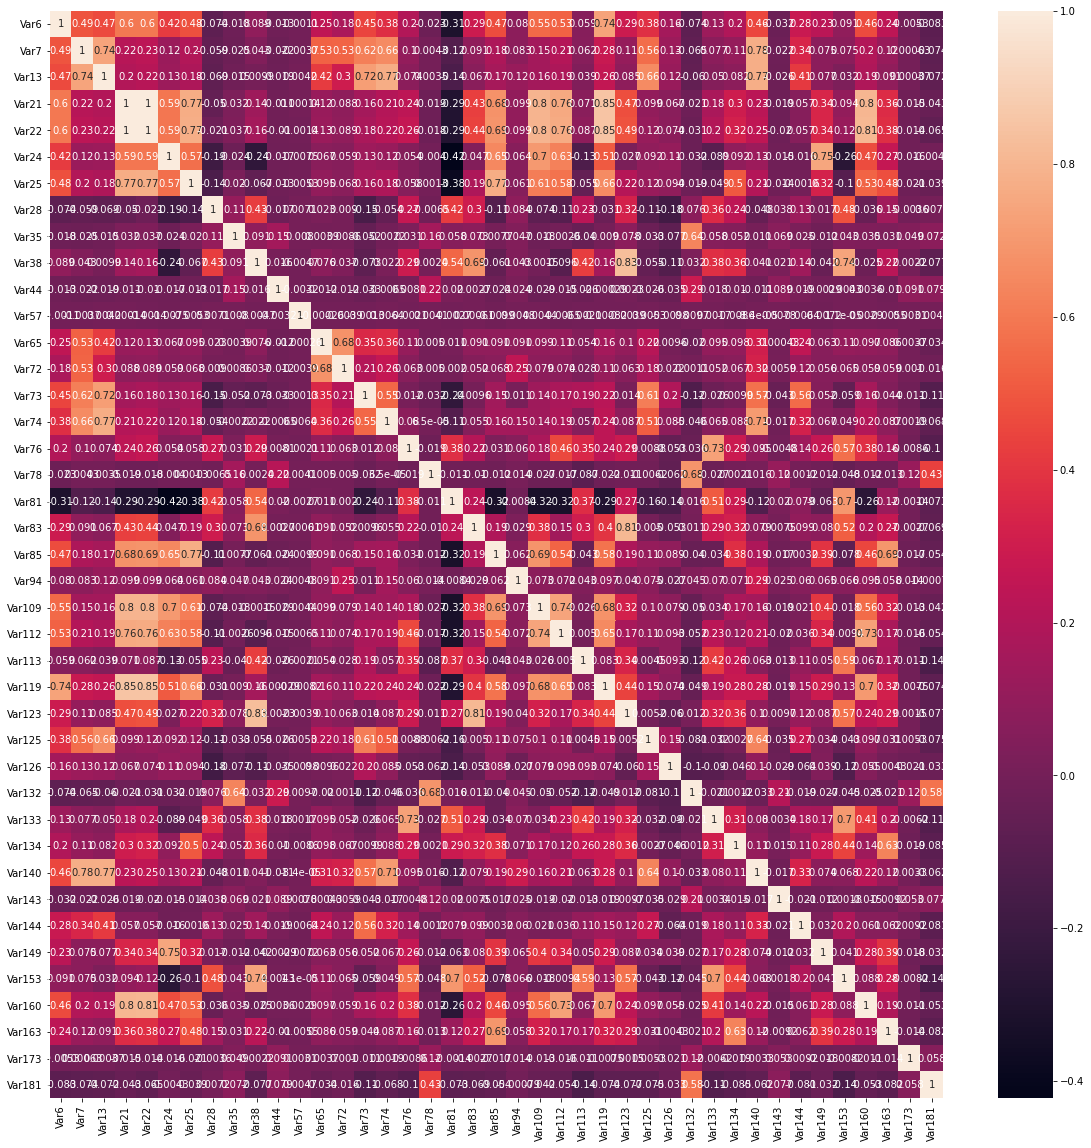

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, annot=True)
plt.show()

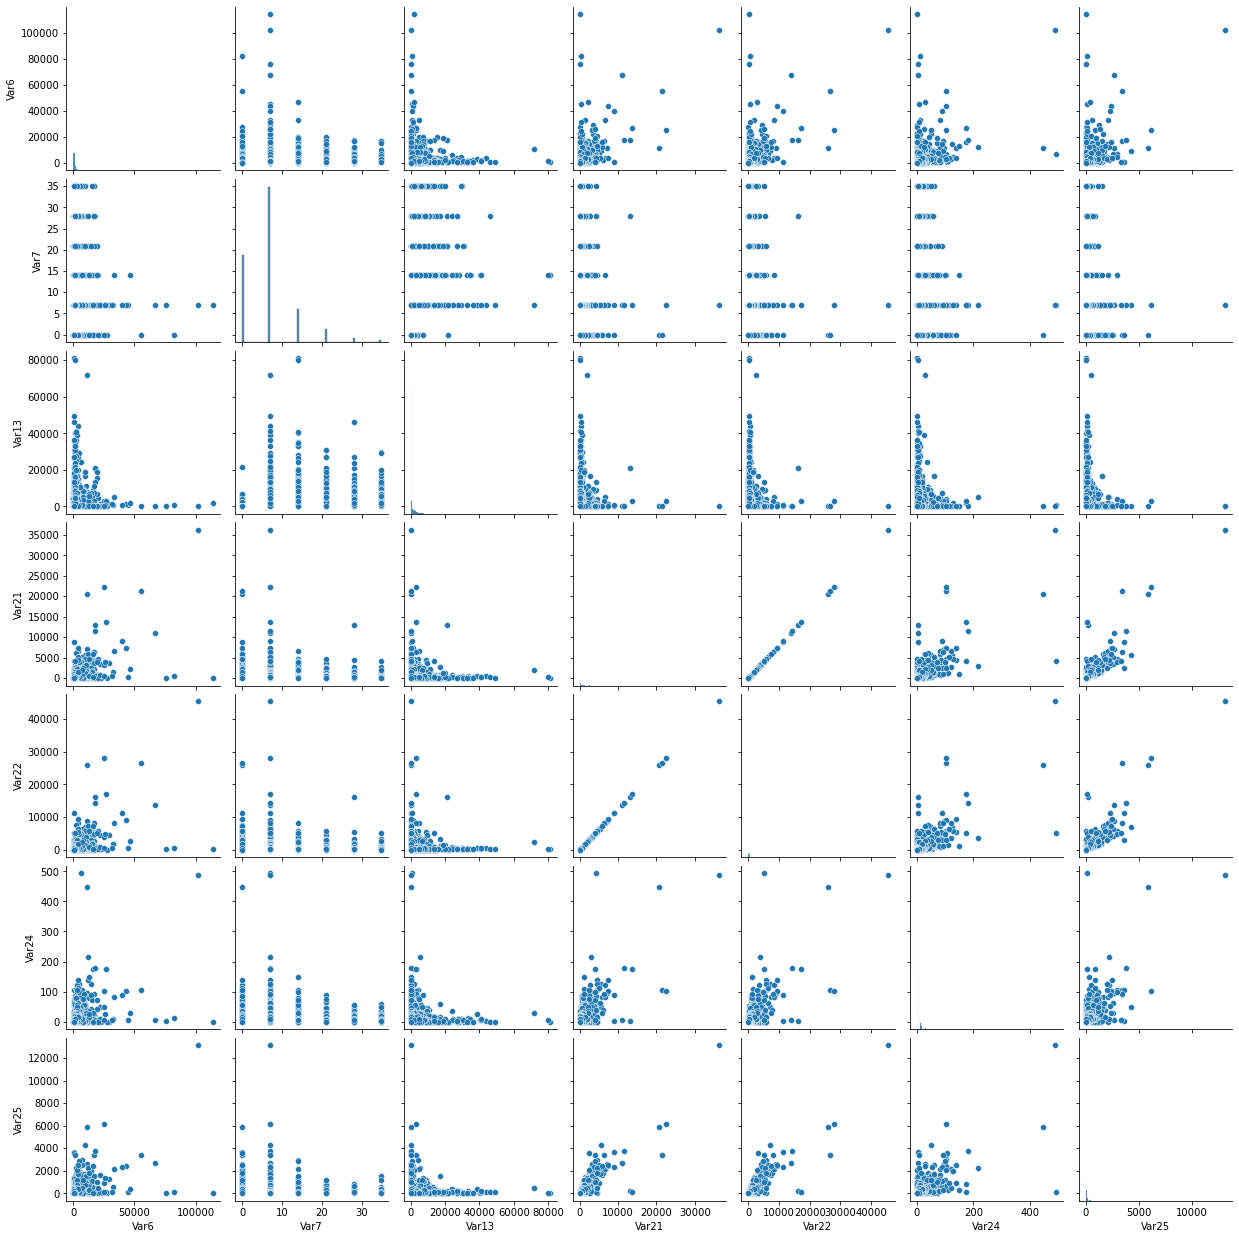

In [15]:
sns.pairplot(data[right_numeric_column[:7]])

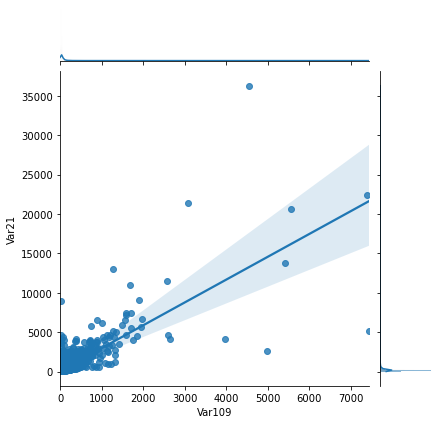

In [16]:
sns.jointplot(x="Var109", y="Var21", data=data, kind='reg')

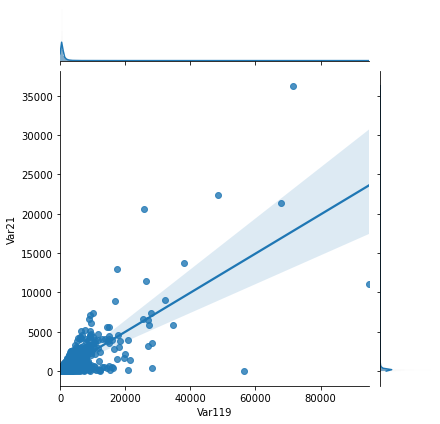

In [17]:
sns.jointplot(x="Var119", y="Var21", data=data, kind='reg')

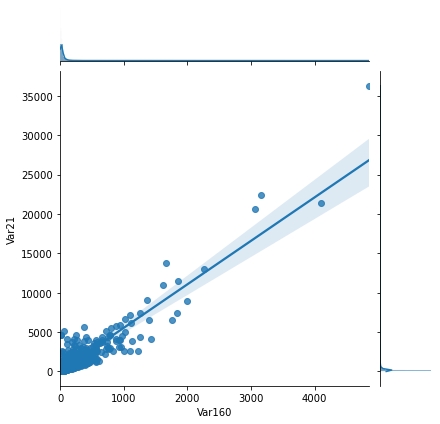

In [18]:
sns.jointplot(x="Var160", y="Var21", data=data, kind='reg')

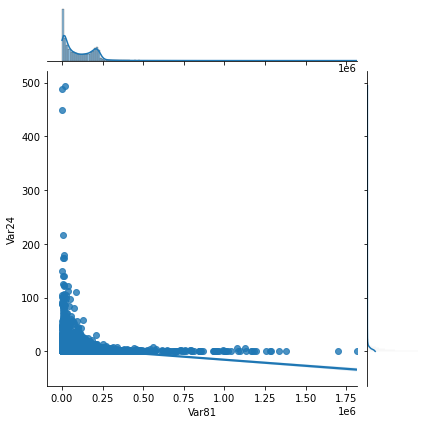

In [19]:
sns.jointplot(x="Var81", y="Var24", data=data, kind='reg')

In [20]:
data_top_corr = []
for i in range(len(corr_map.columns)-1):
    cur_name = corr_map.columns[i]
    other_columns = corr_map.columns[corr_map.columns != cur_name]
    data_top_corr.append([cur_name, corr_map.loc[corr_map.index == cur_name, other_columns].idxmax(axis=1).to_numpy()[0]])

In [21]:
data_top_corr[:5]

[['Var6', 'Var119'],
 ['Var7', 'Var140'],
 ['Var13', 'Var140'],
 ['Var21', 'Var22'],
 ['Var22', 'Var21']]

<Figure size 432x288 with 0 Axes>

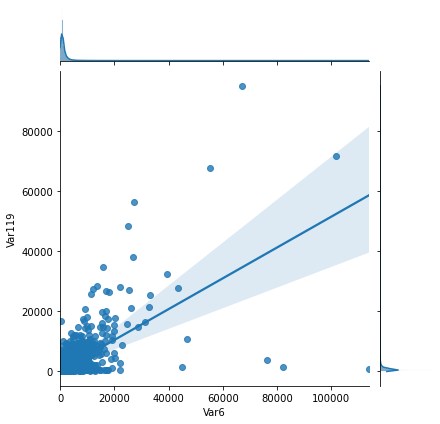

<Figure size 432x288 with 0 Axes>

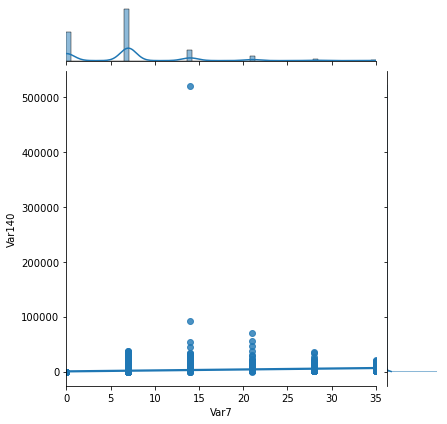

<Figure size 432x288 with 0 Axes>

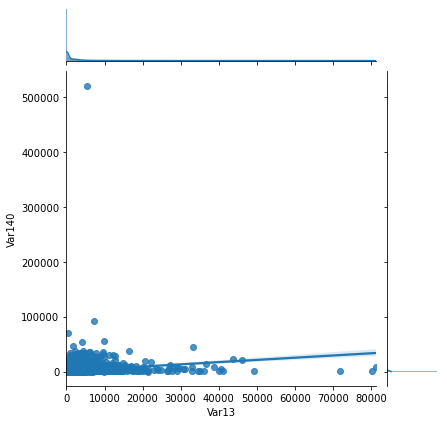

<Figure size 432x288 with 0 Axes>

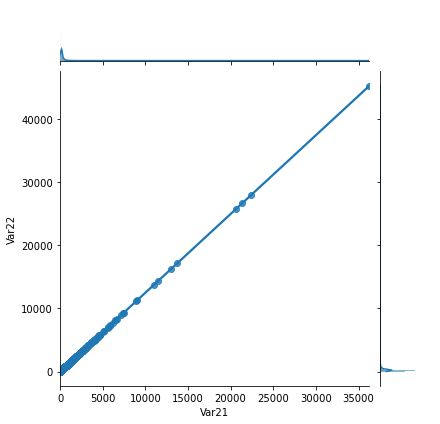

<Figure size 432x288 with 0 Axes>

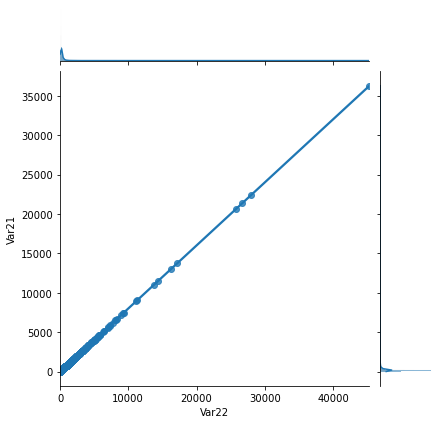

<Figure size 432x288 with 0 Axes>

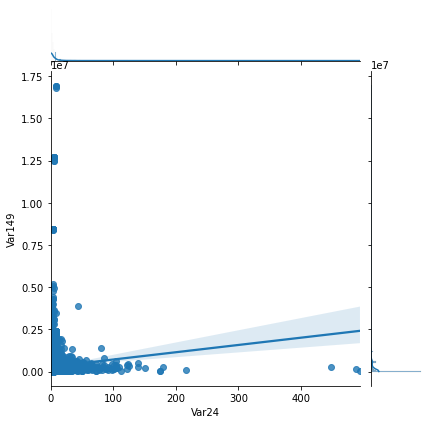

<Figure size 432x288 with 0 Axes>

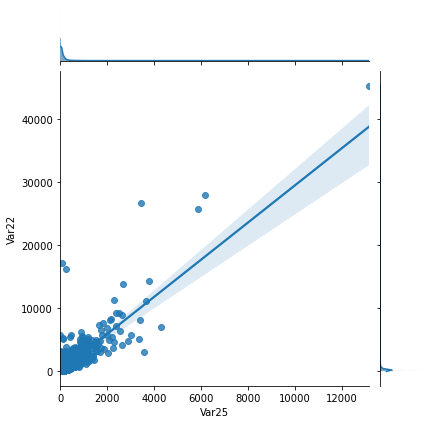

<Figure size 432x288 with 0 Axes>

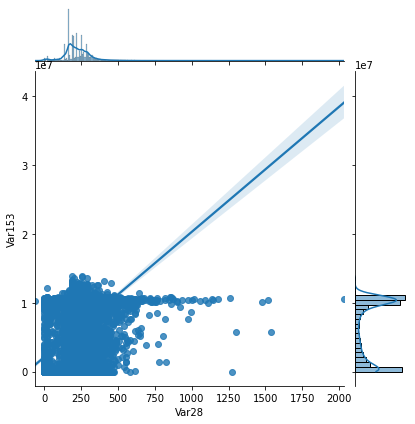

<Figure size 432x288 with 0 Axes>

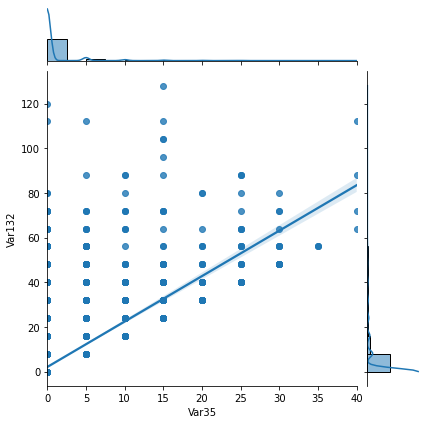

<Figure size 432x288 with 0 Axes>

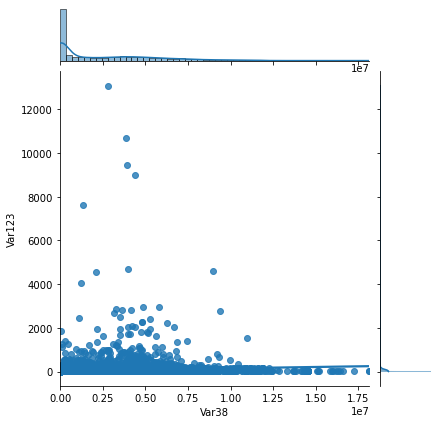

<Figure size 432x288 with 0 Axes>

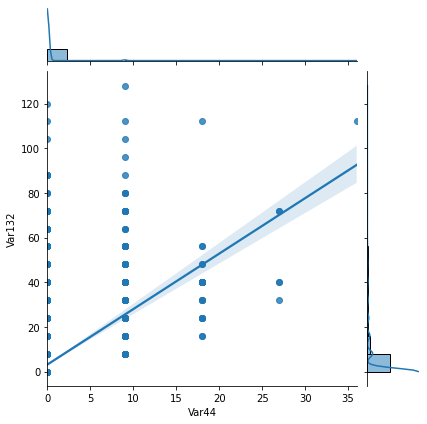

<Figure size 432x288 with 0 Axes>

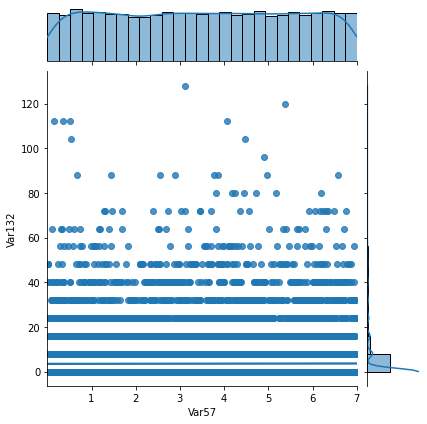

<Figure size 432x288 with 0 Axes>

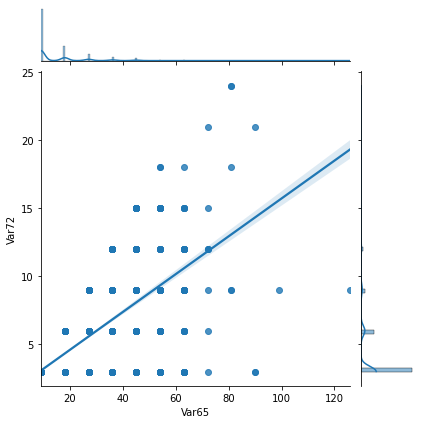

<Figure size 432x288 with 0 Axes>

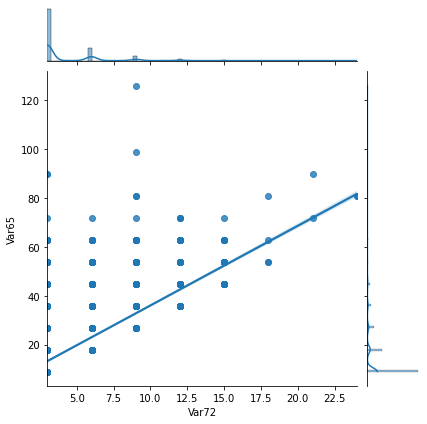

<Figure size 432x288 with 0 Axes>

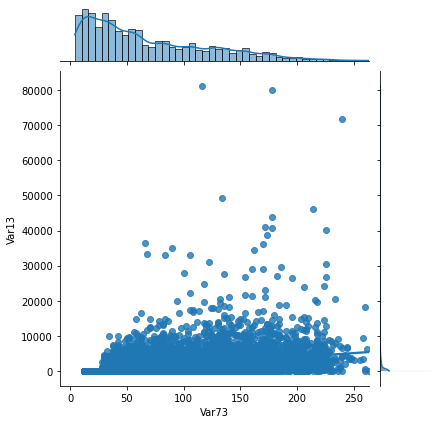

<Figure size 432x288 with 0 Axes>

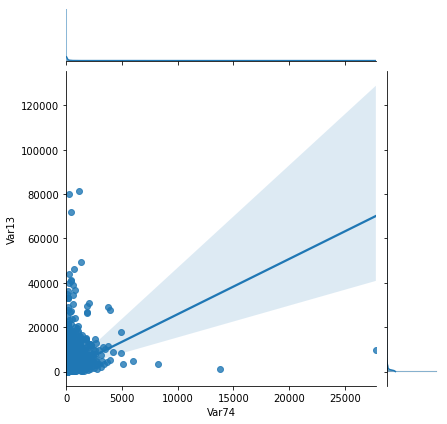

<Figure size 432x288 with 0 Axes>

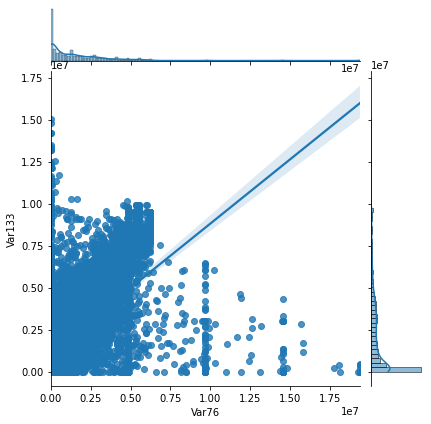

<Figure size 432x288 with 0 Axes>

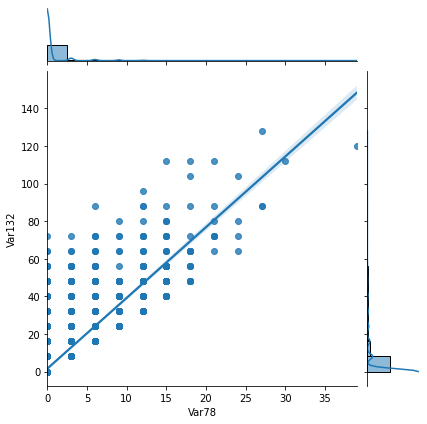

<Figure size 432x288 with 0 Axes>

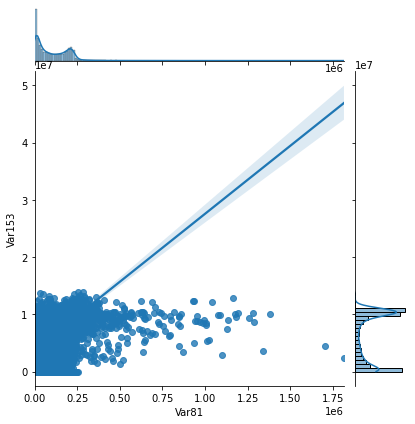

<Figure size 432x288 with 0 Axes>

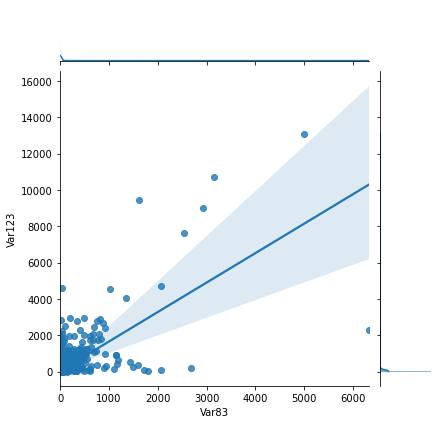

<Figure size 432x288 with 0 Axes>

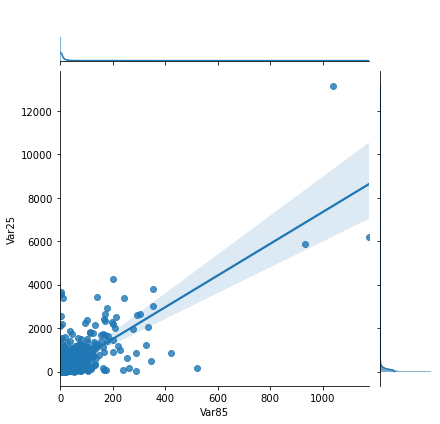

<Figure size 432x288 with 0 Axes>

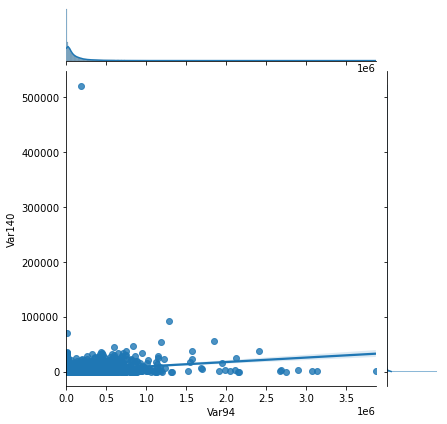

<Figure size 432x288 with 0 Axes>

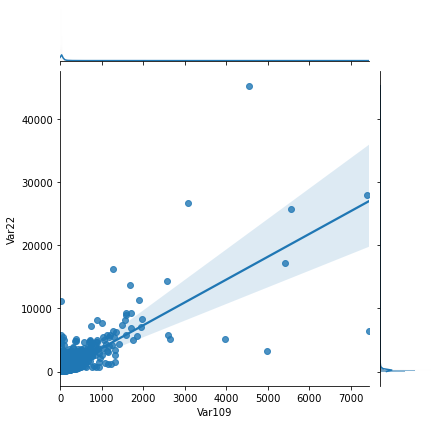

<Figure size 432x288 with 0 Axes>

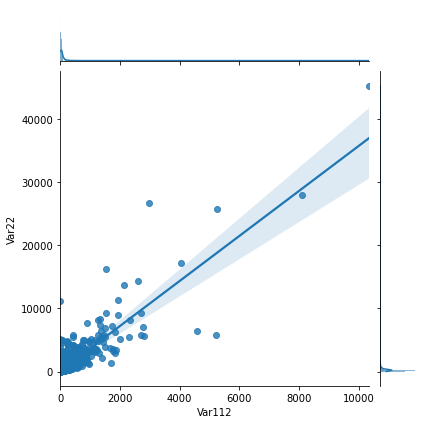

<Figure size 432x288 with 0 Axes>

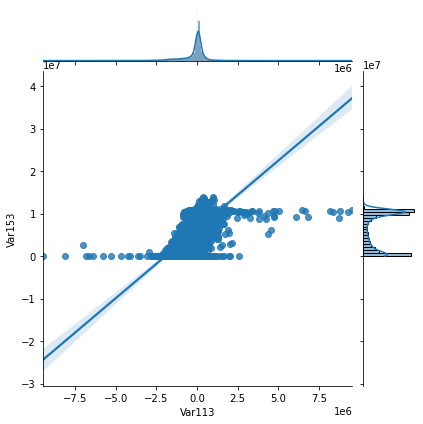

<Figure size 432x288 with 0 Axes>

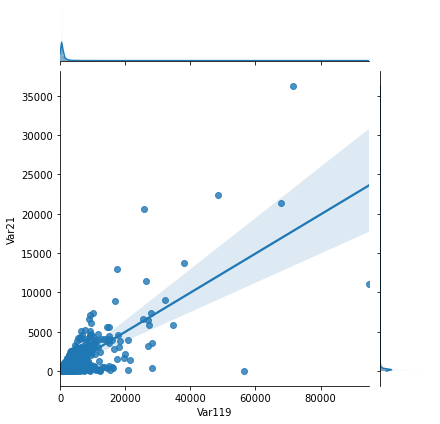

<Figure size 432x288 with 0 Axes>

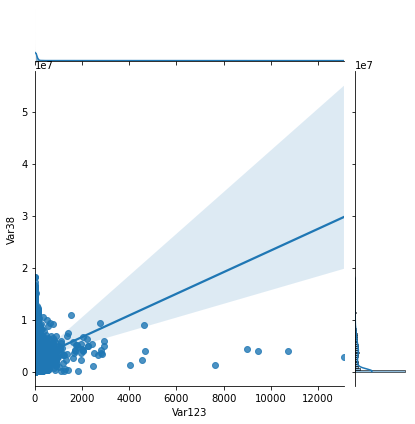

<Figure size 432x288 with 0 Axes>

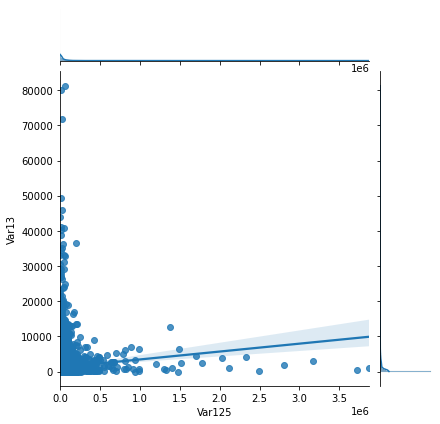

<Figure size 432x288 with 0 Axes>

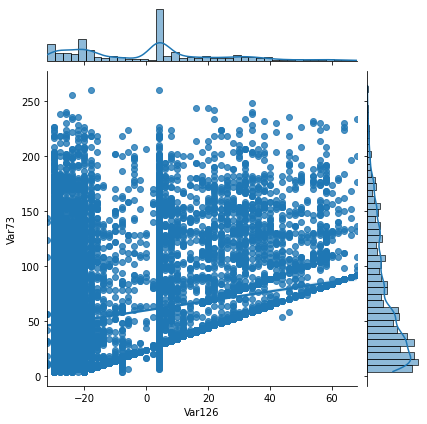

<Figure size 432x288 with 0 Axes>

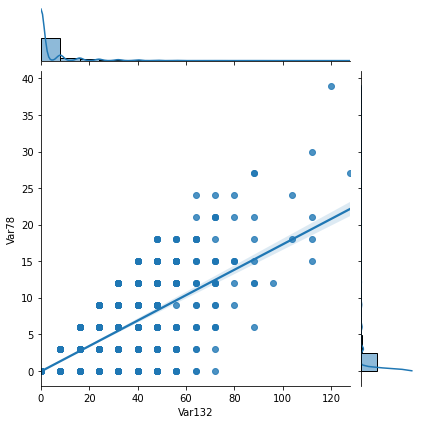

<Figure size 432x288 with 0 Axes>

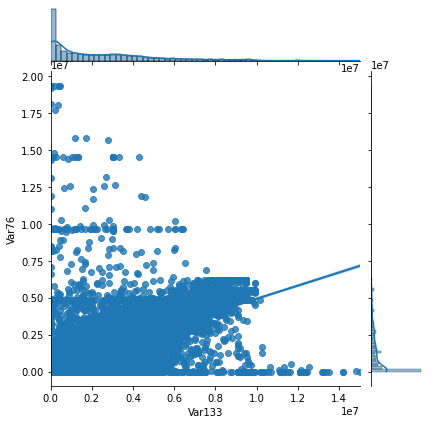

<Figure size 432x288 with 0 Axes>

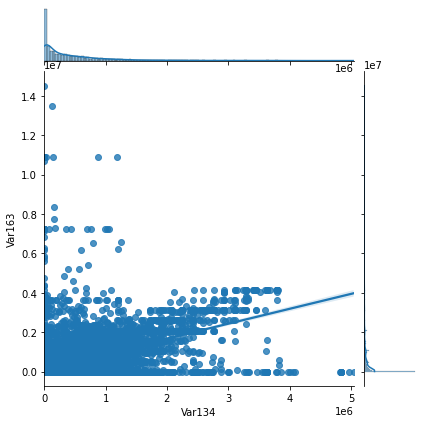

<Figure size 432x288 with 0 Axes>

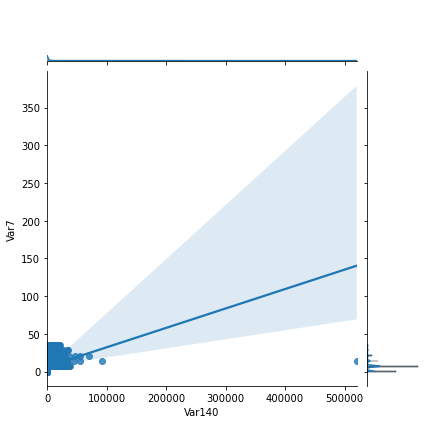

<Figure size 432x288 with 0 Axes>

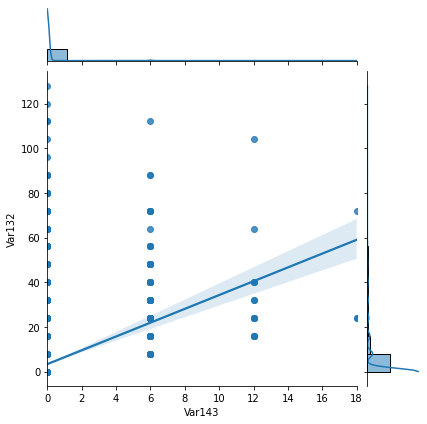

<Figure size 432x288 with 0 Axes>

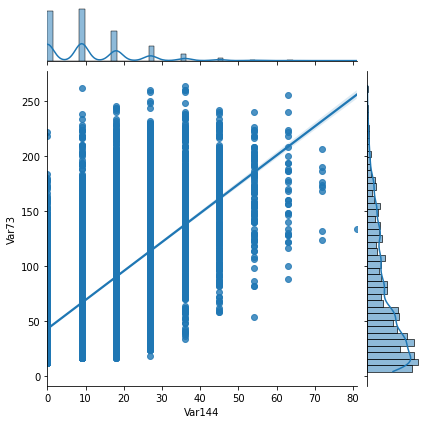

<Figure size 432x288 with 0 Axes>

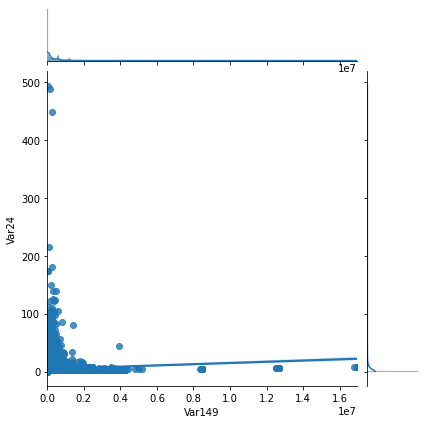

<Figure size 432x288 with 0 Axes>

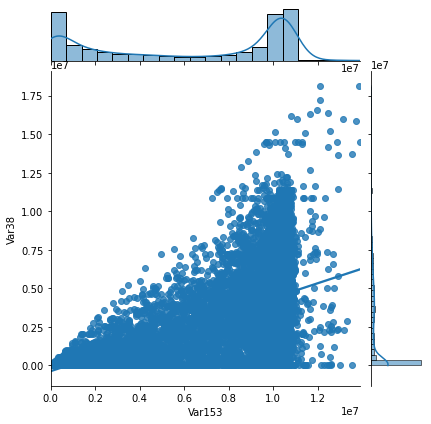

<Figure size 432x288 with 0 Axes>

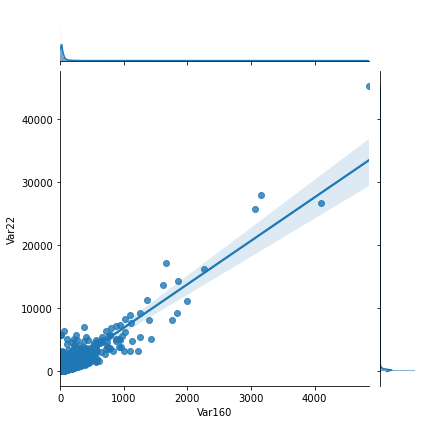

<Figure size 432x288 with 0 Axes>

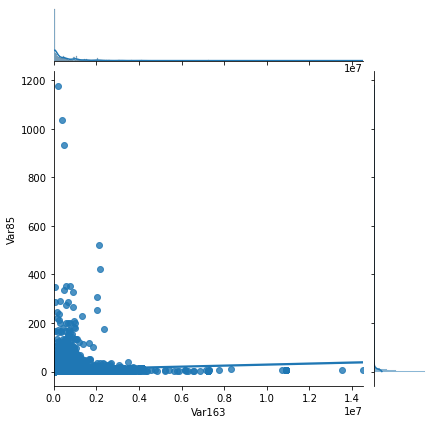

<Figure size 432x288 with 0 Axes>

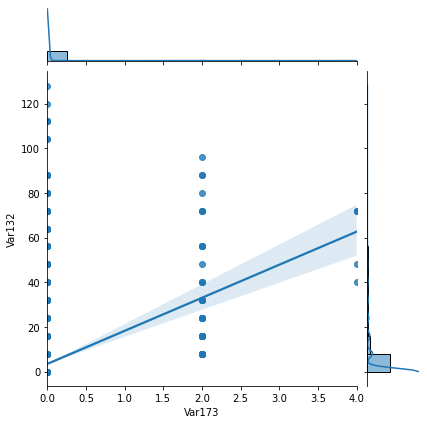

In [22]:
for n_1, n_2 in data_top_corr:
    plt.figure()
    sns.jointplot(x=n_1, y=n_2, data=data, kind='reg')
    plt.show()

In [23]:
data['Var21'].describe()

count    16307.000000
mean       235.956338
std        580.036843
min          0.000000
25%        112.000000
50%        144.000000
75%        232.000000
max      36272.000000
Name: Var21, dtype: float64

<AxesSubplot:>

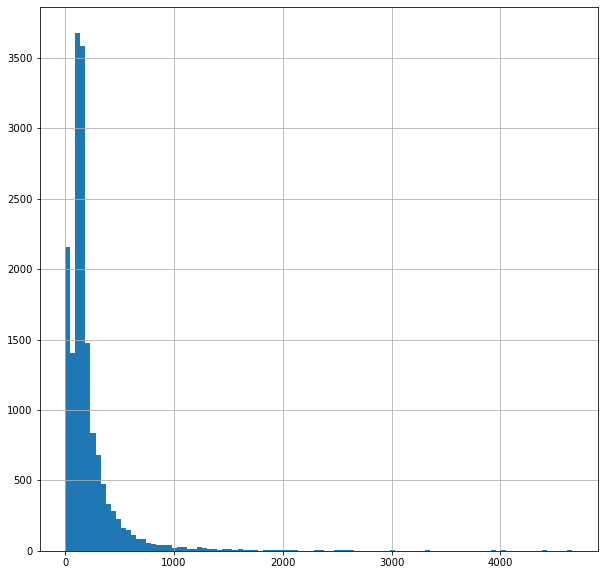

In [24]:
data[data['Var21'] < 5000]['Var21'].hist(bins=100, figsize=(10,10))

Drop numeric feature for corr each other: 21, 22, 25, 160, 109, 112. drop feature from list except 21

In [25]:
right_columns_numeric_1 = right_numeric_column[~right_numeric_column.isin(['Var22', 'Var25','Var160','Var109',
                                                                           'Var112'])]

In [26]:
# cat feature

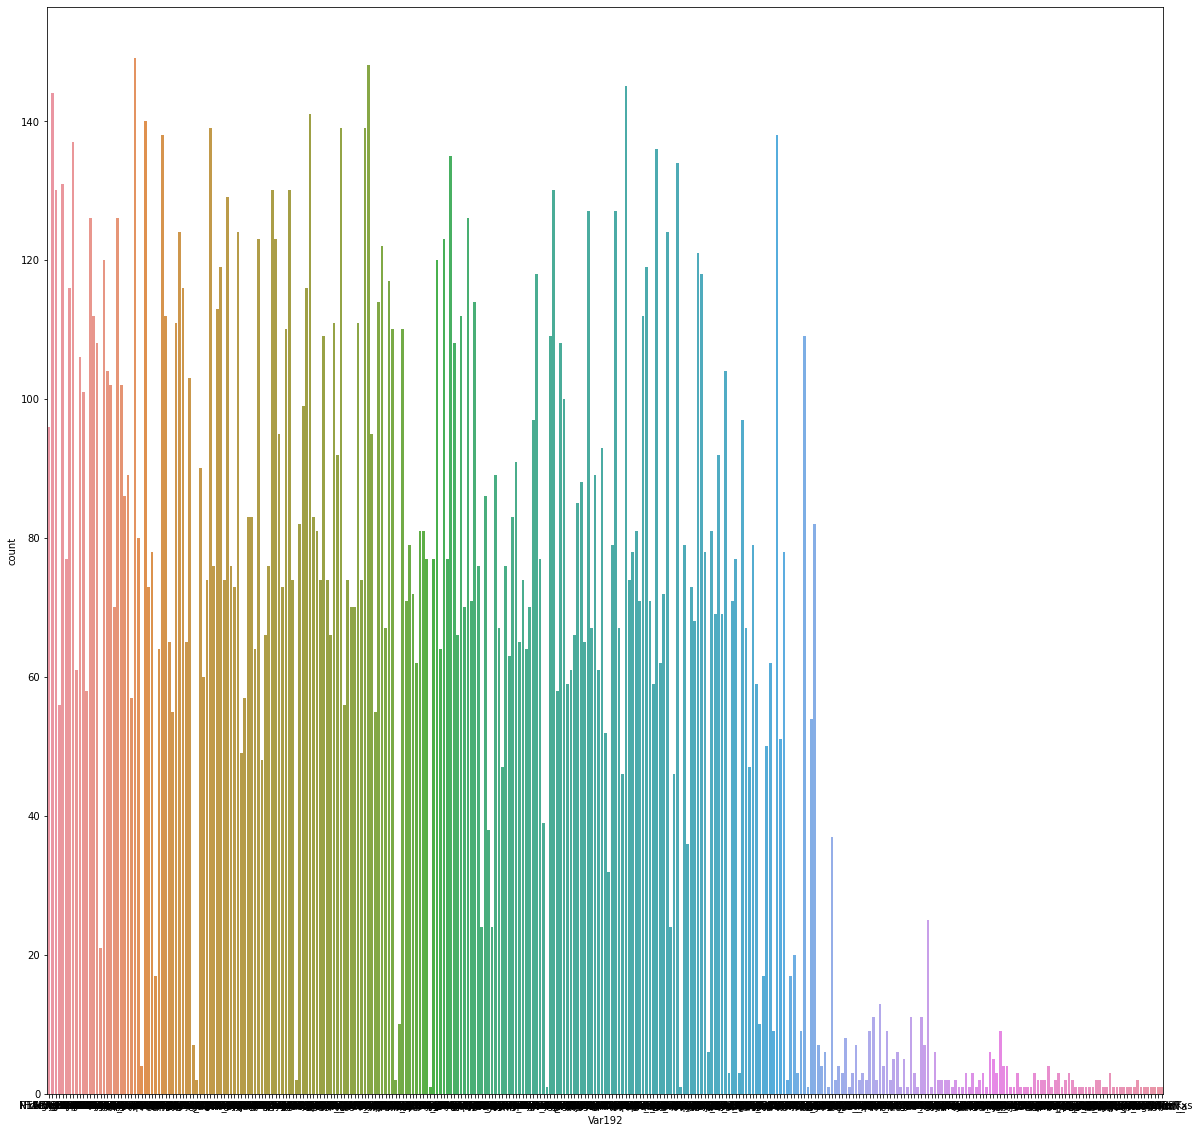

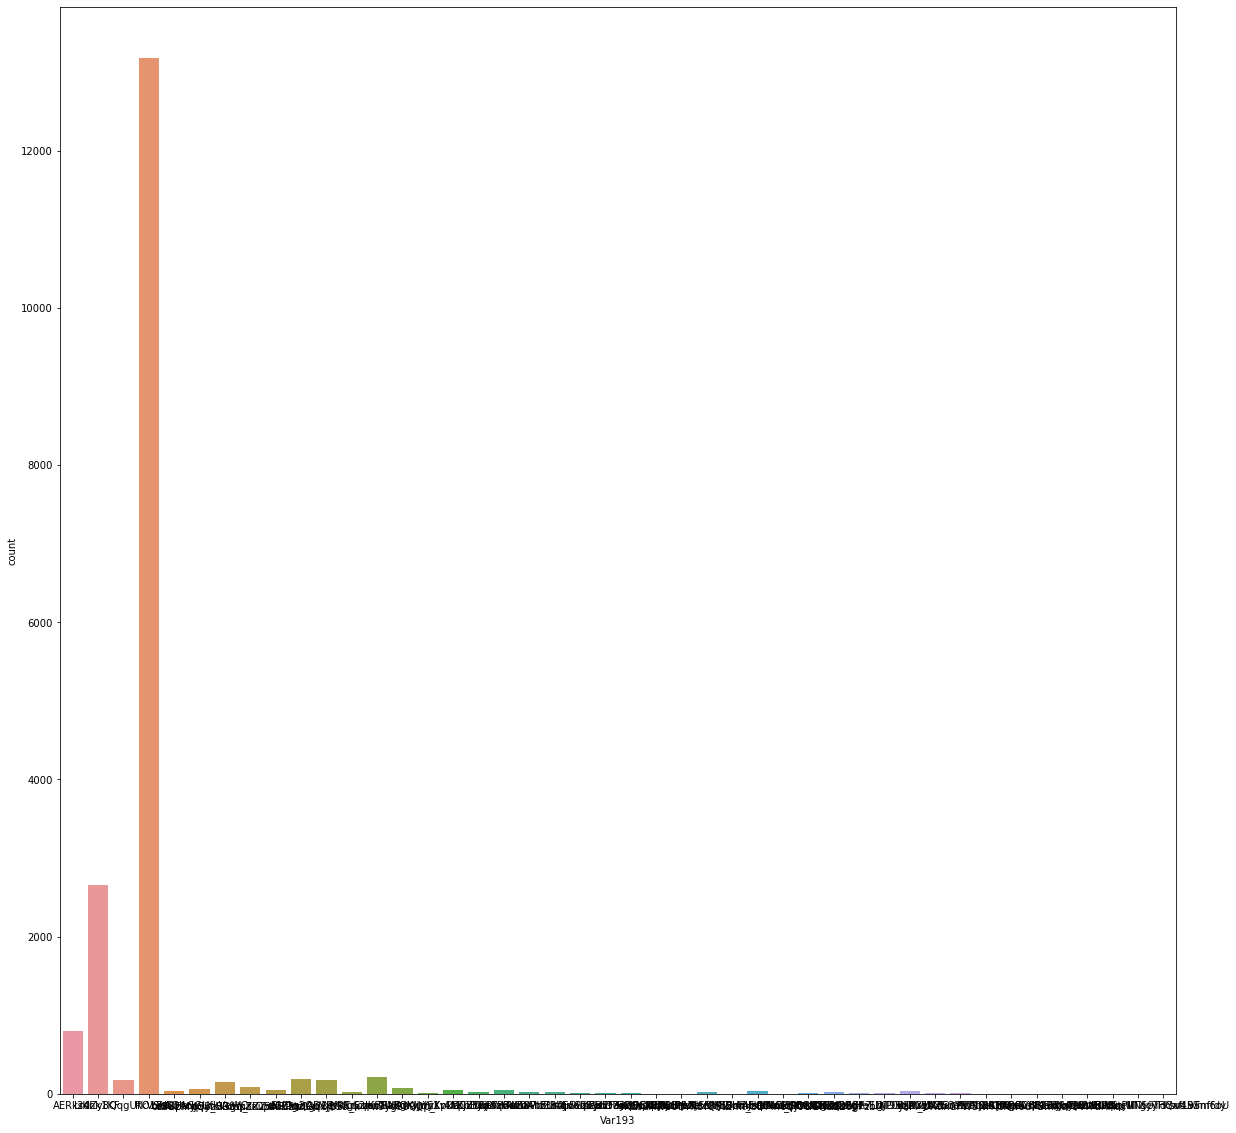

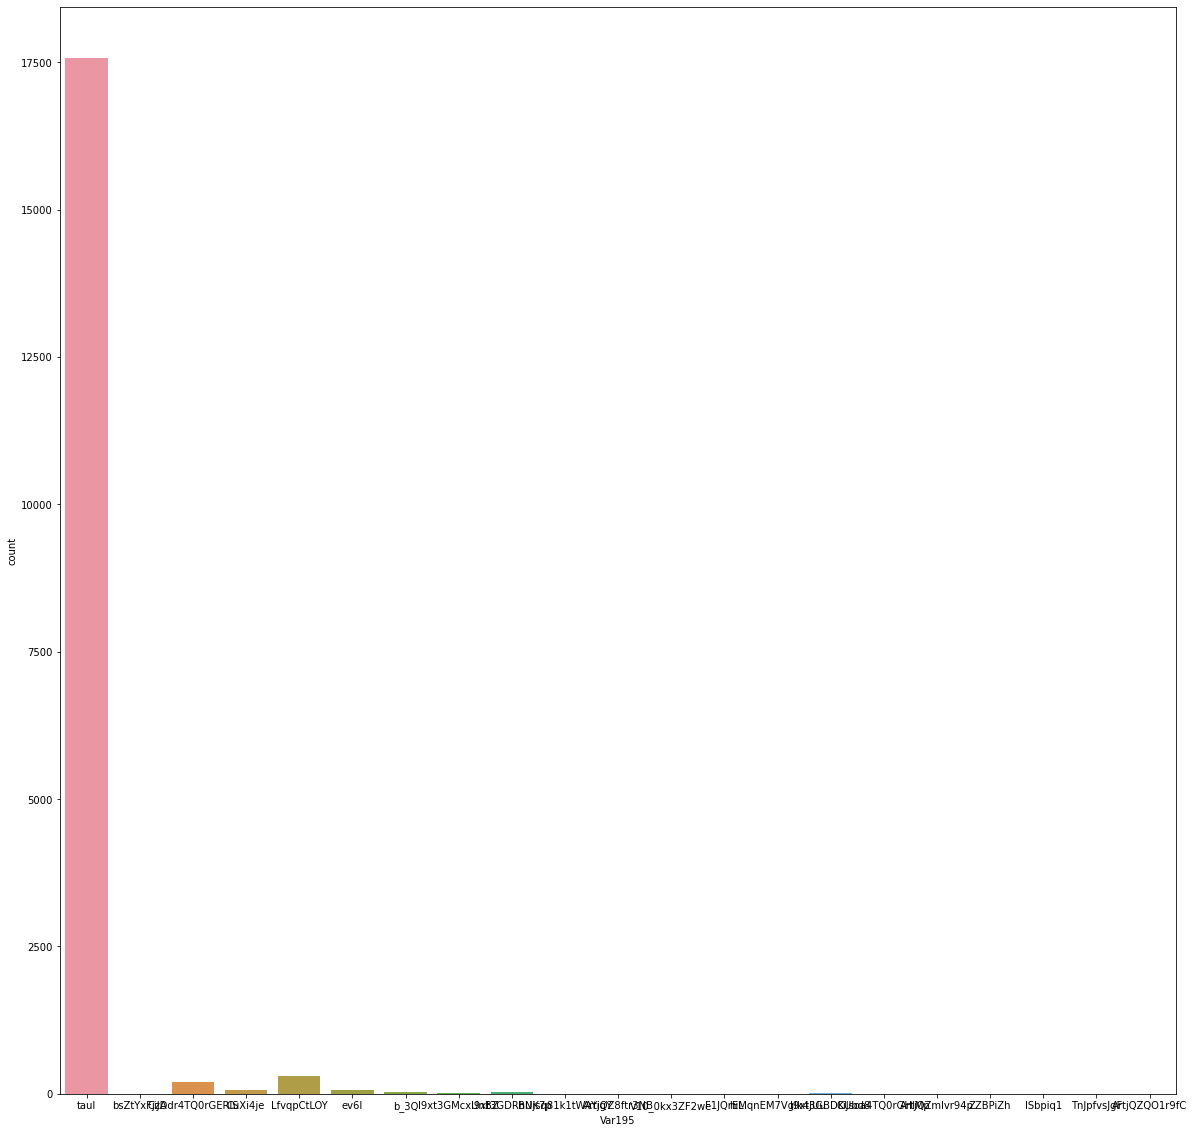

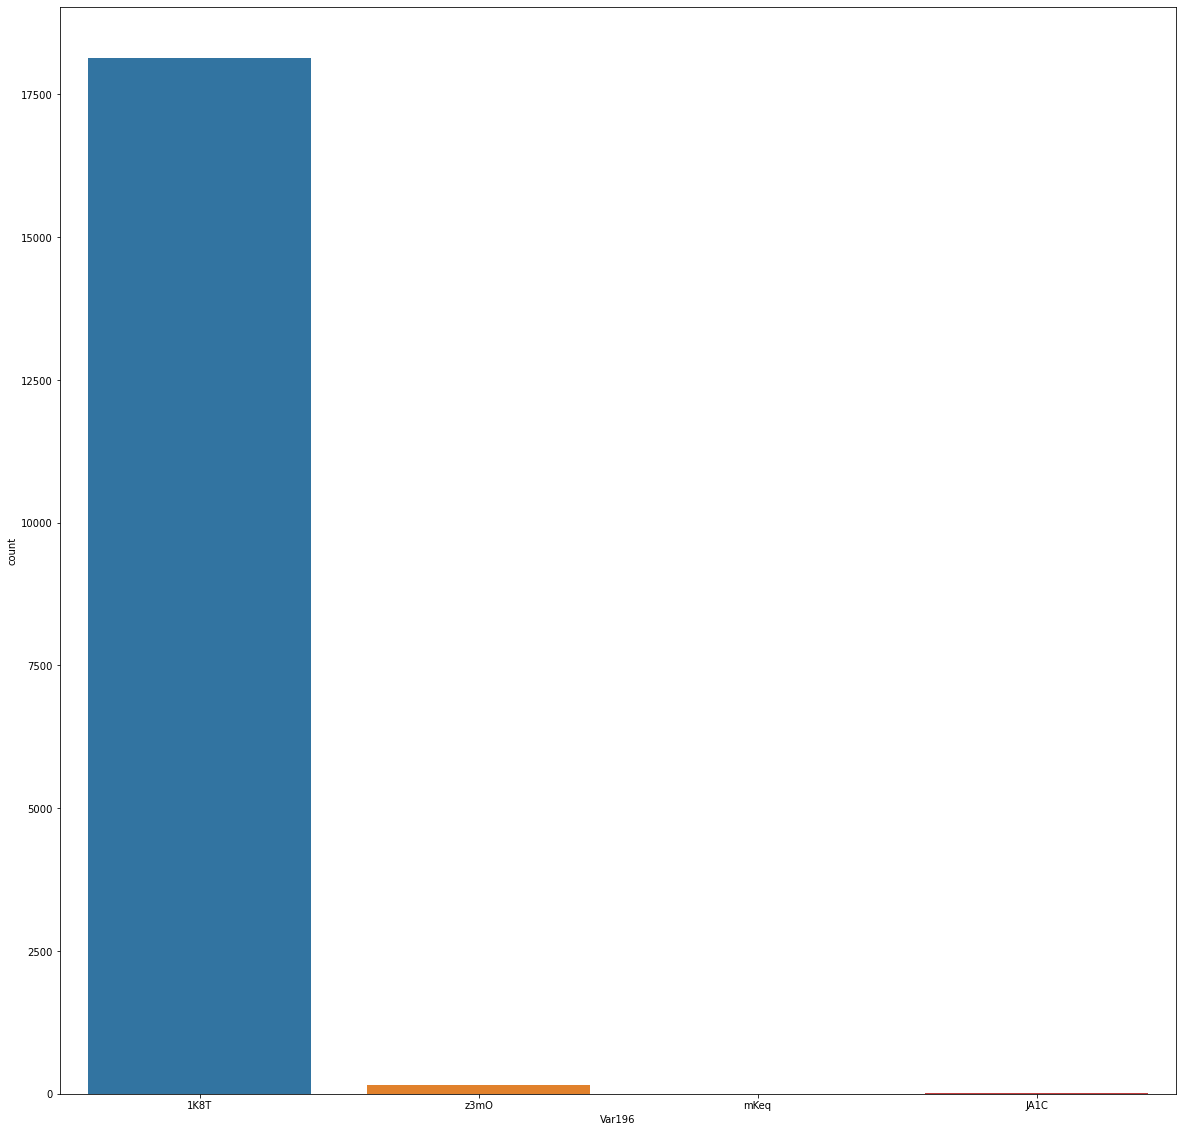

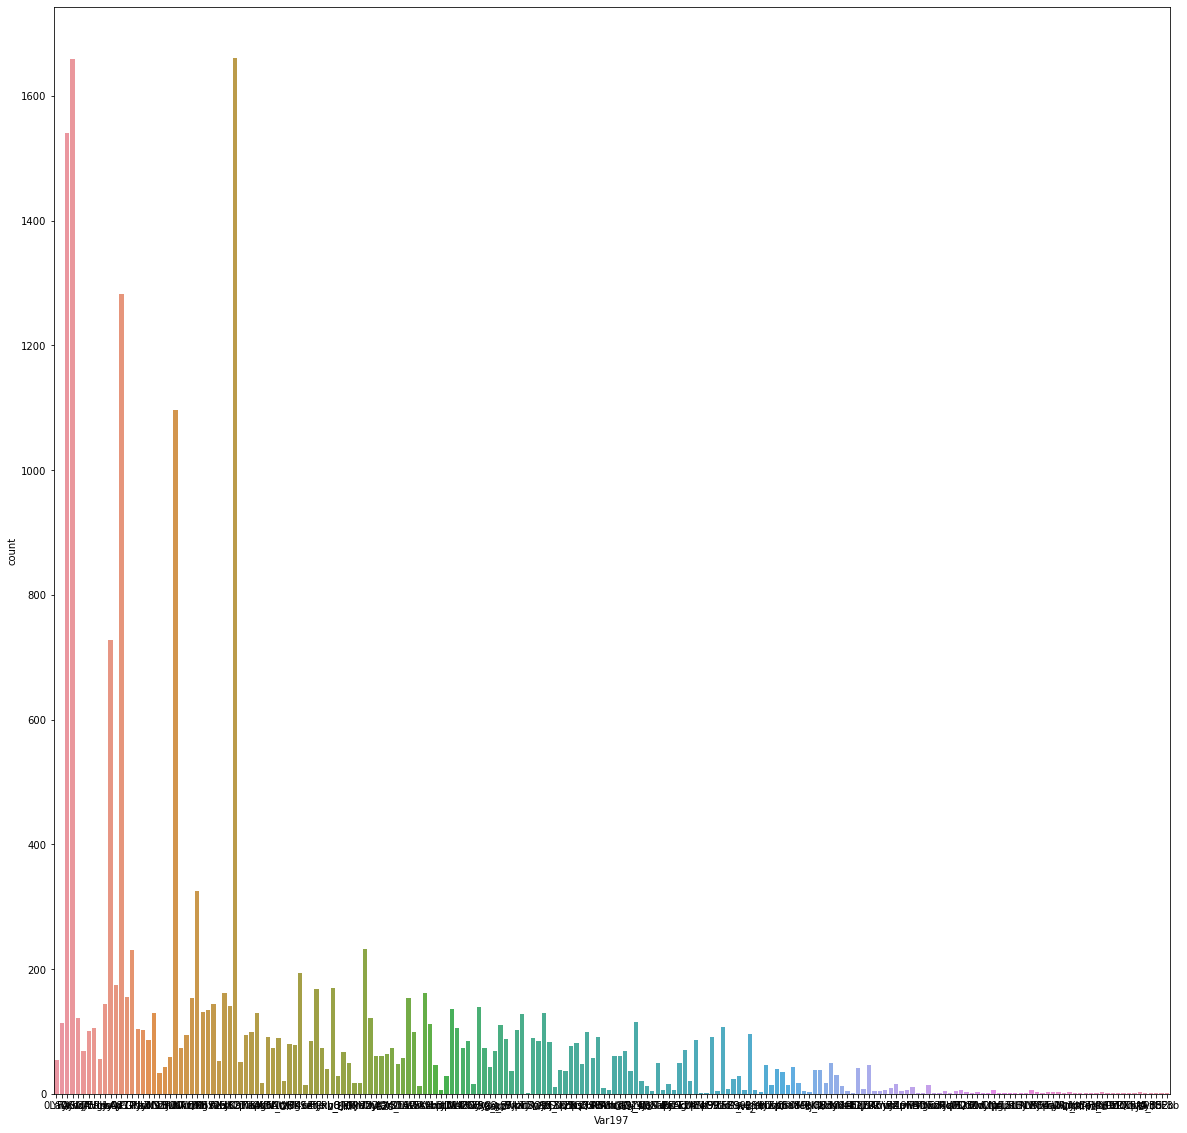

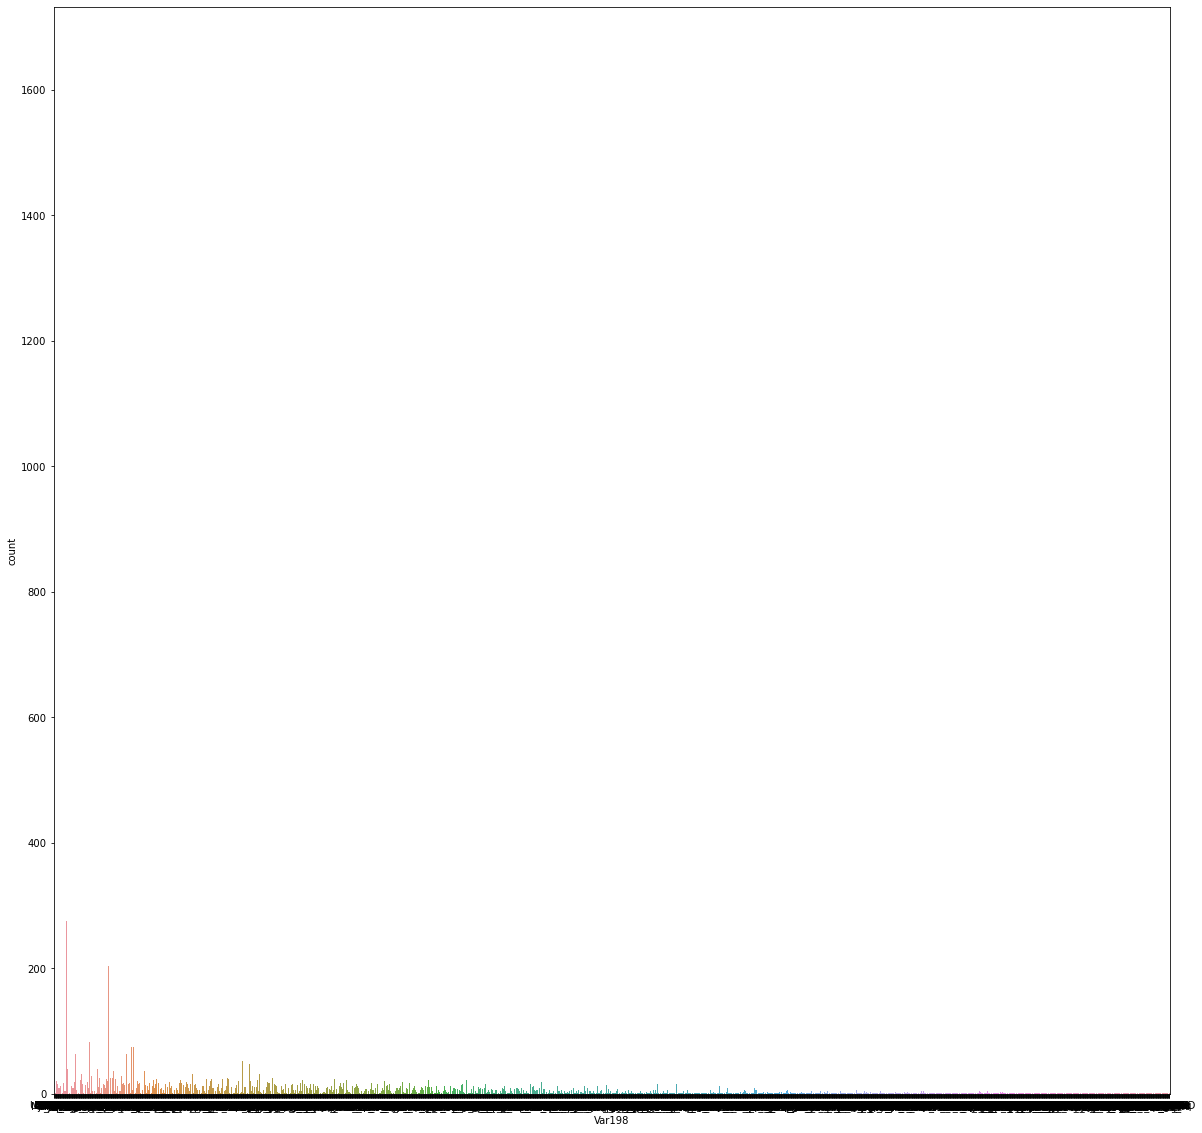

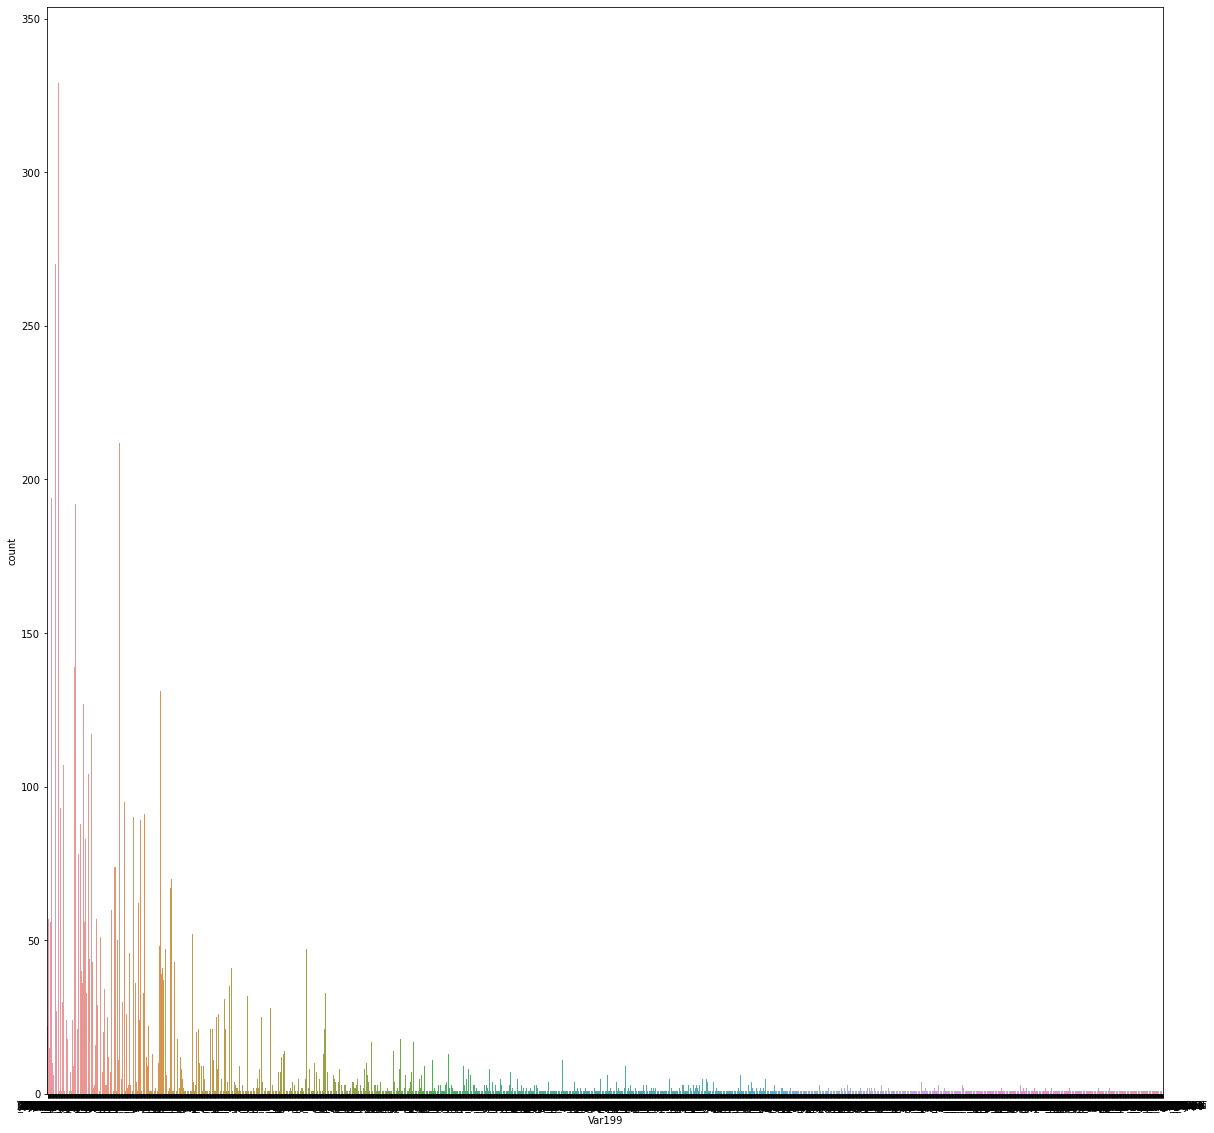

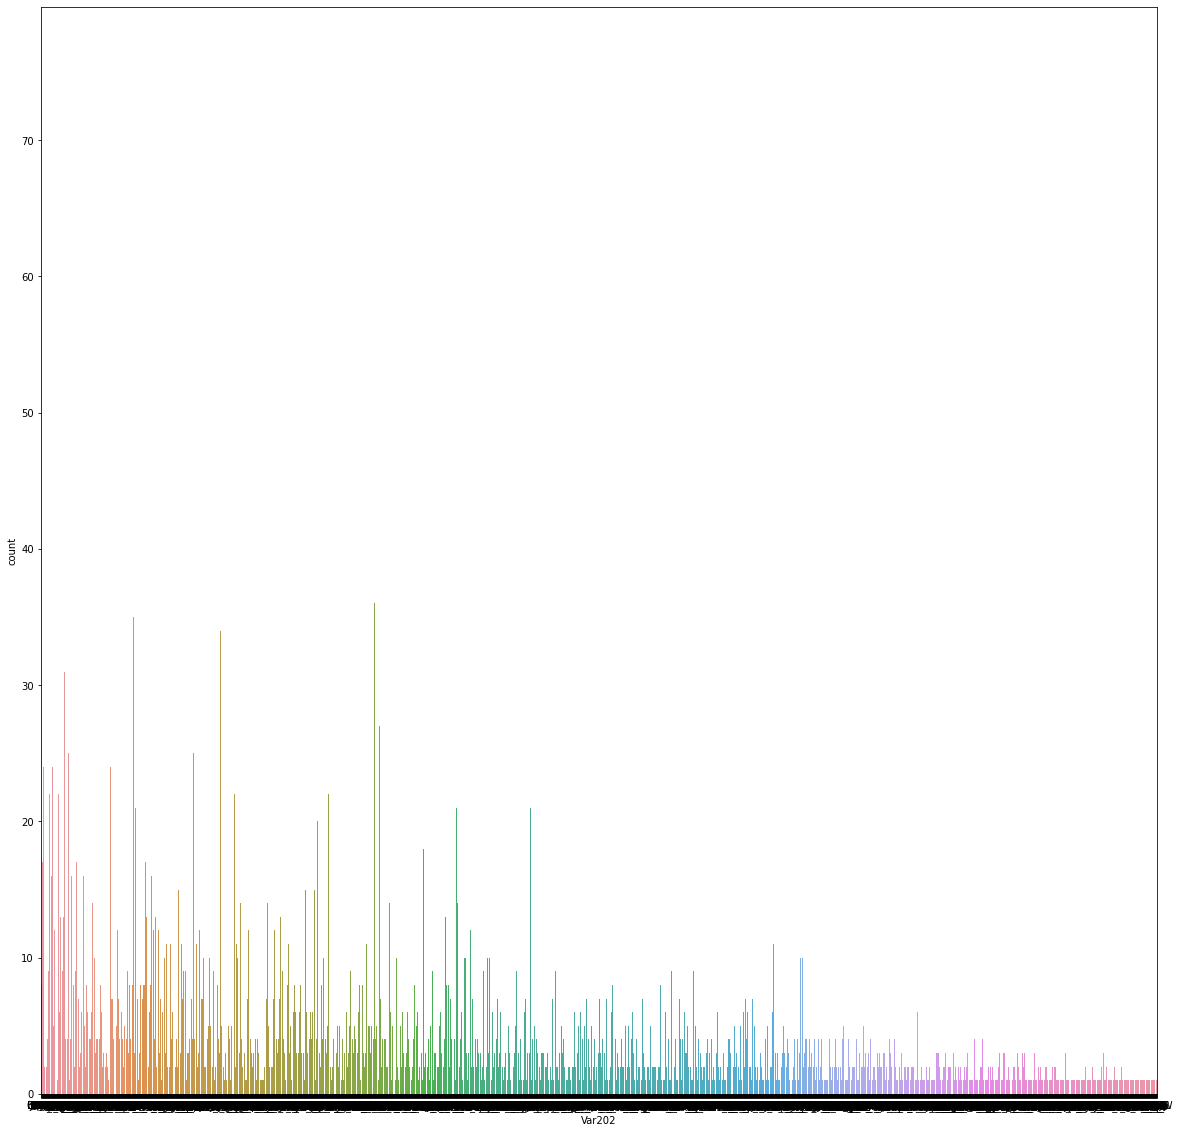

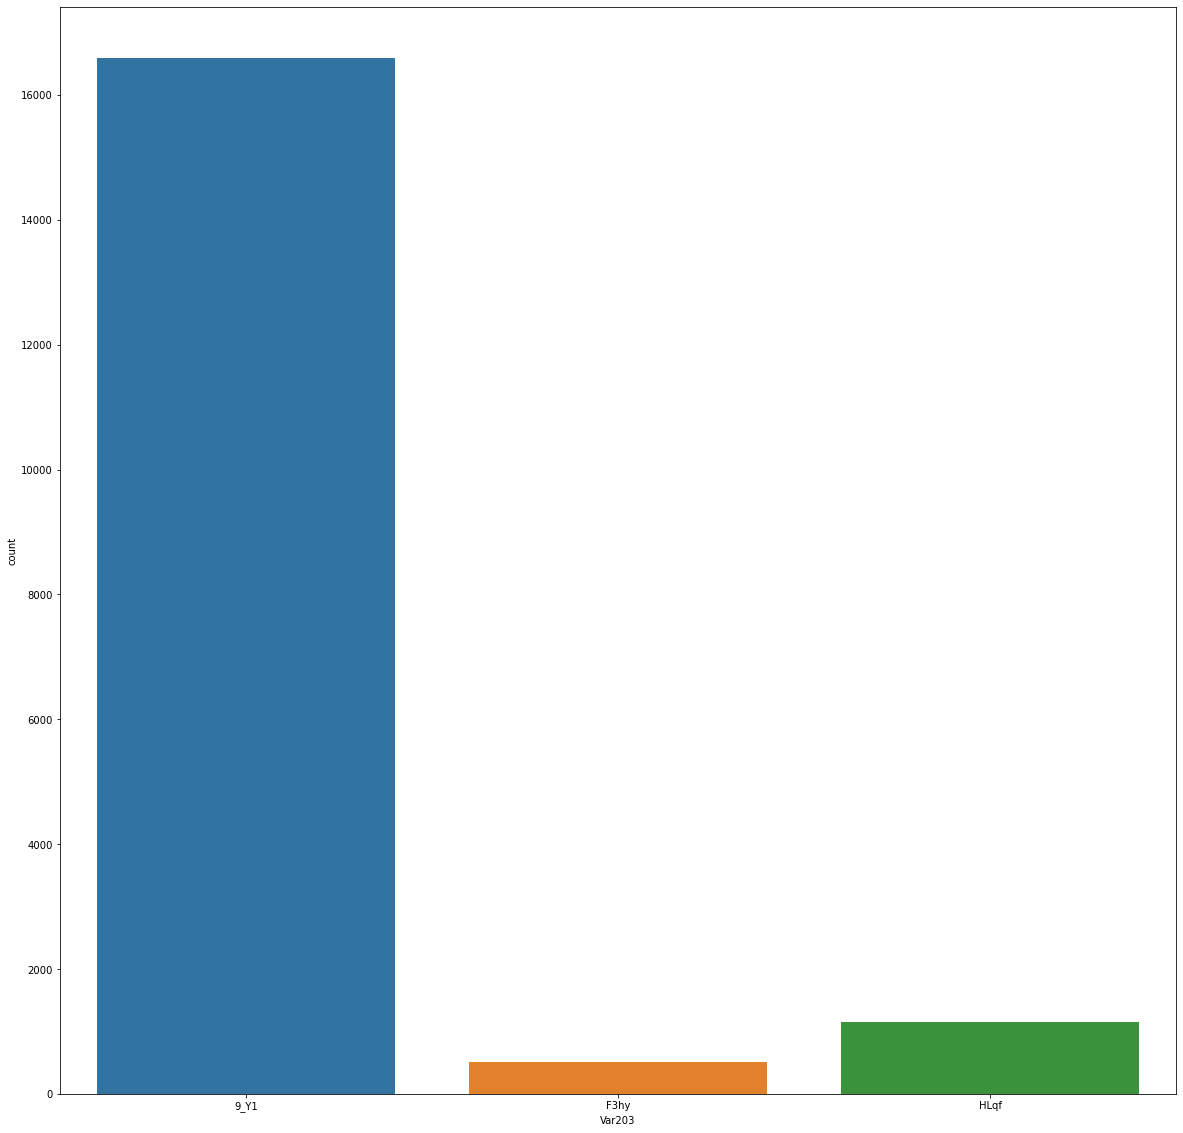

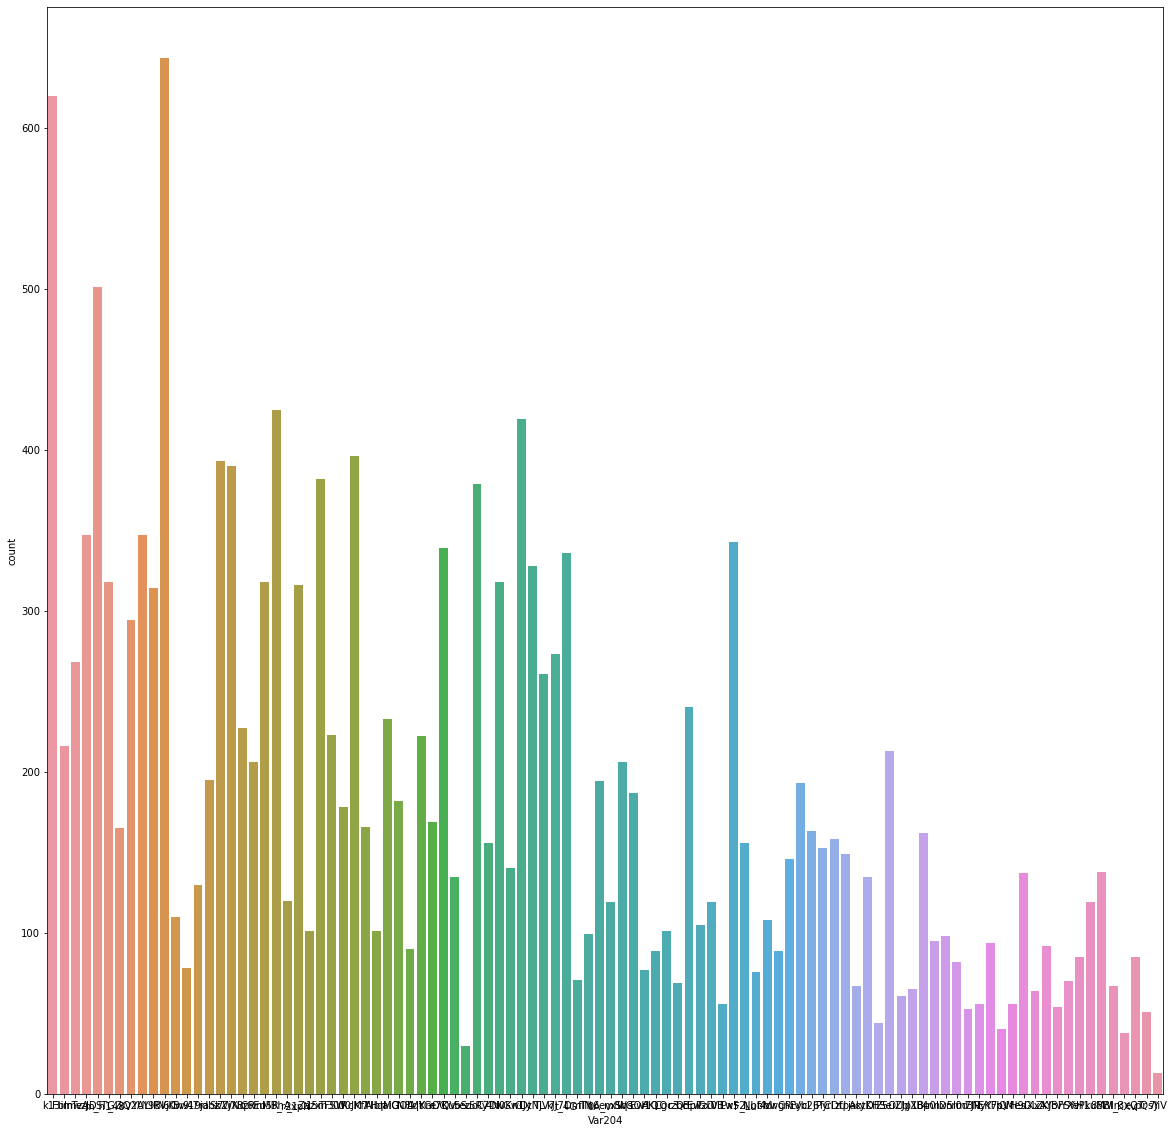

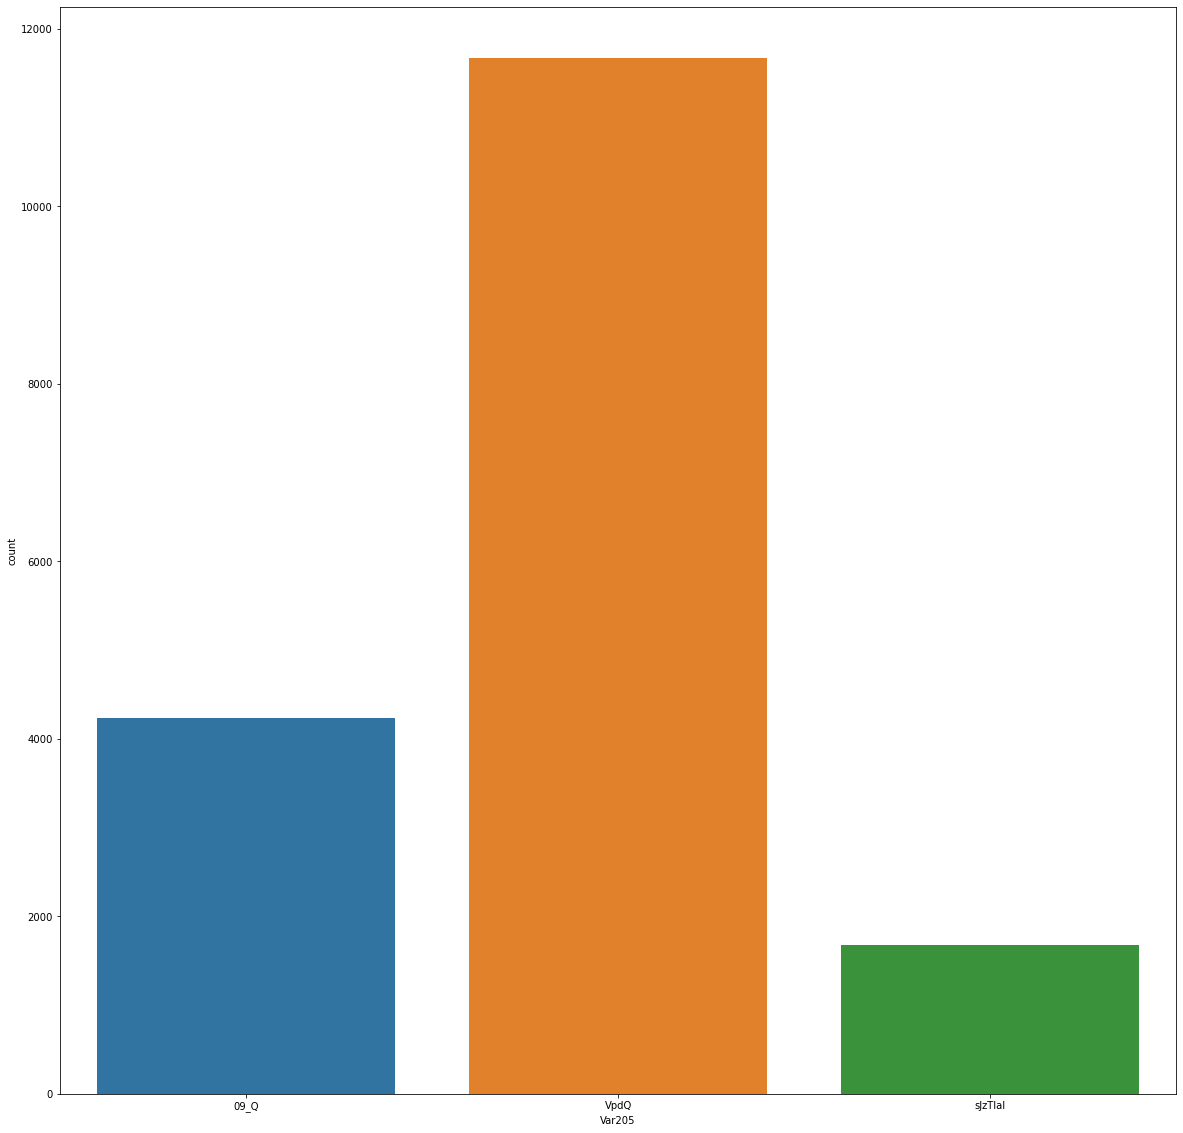

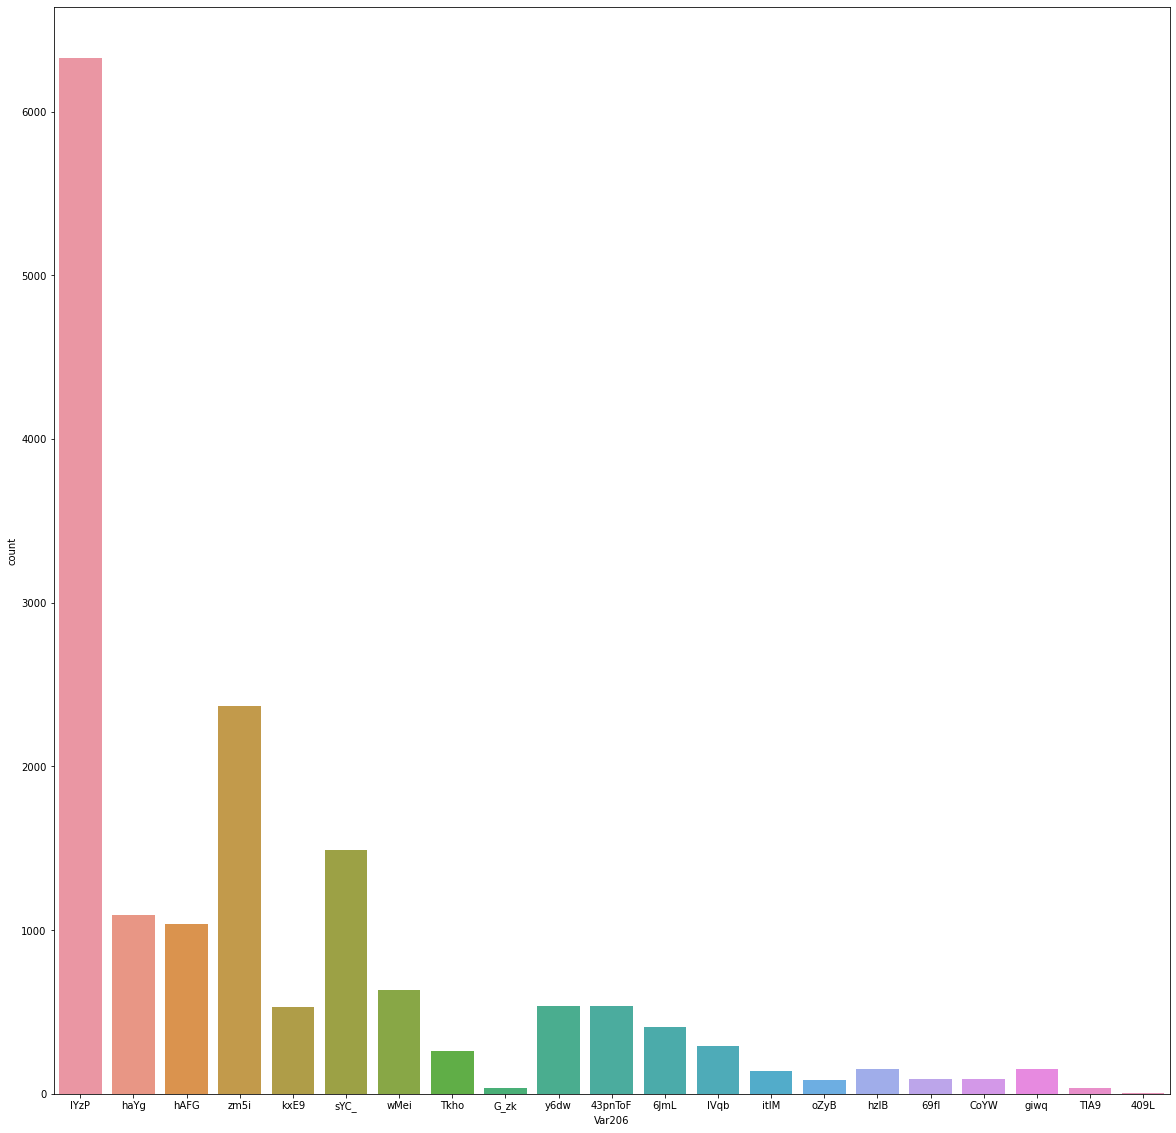

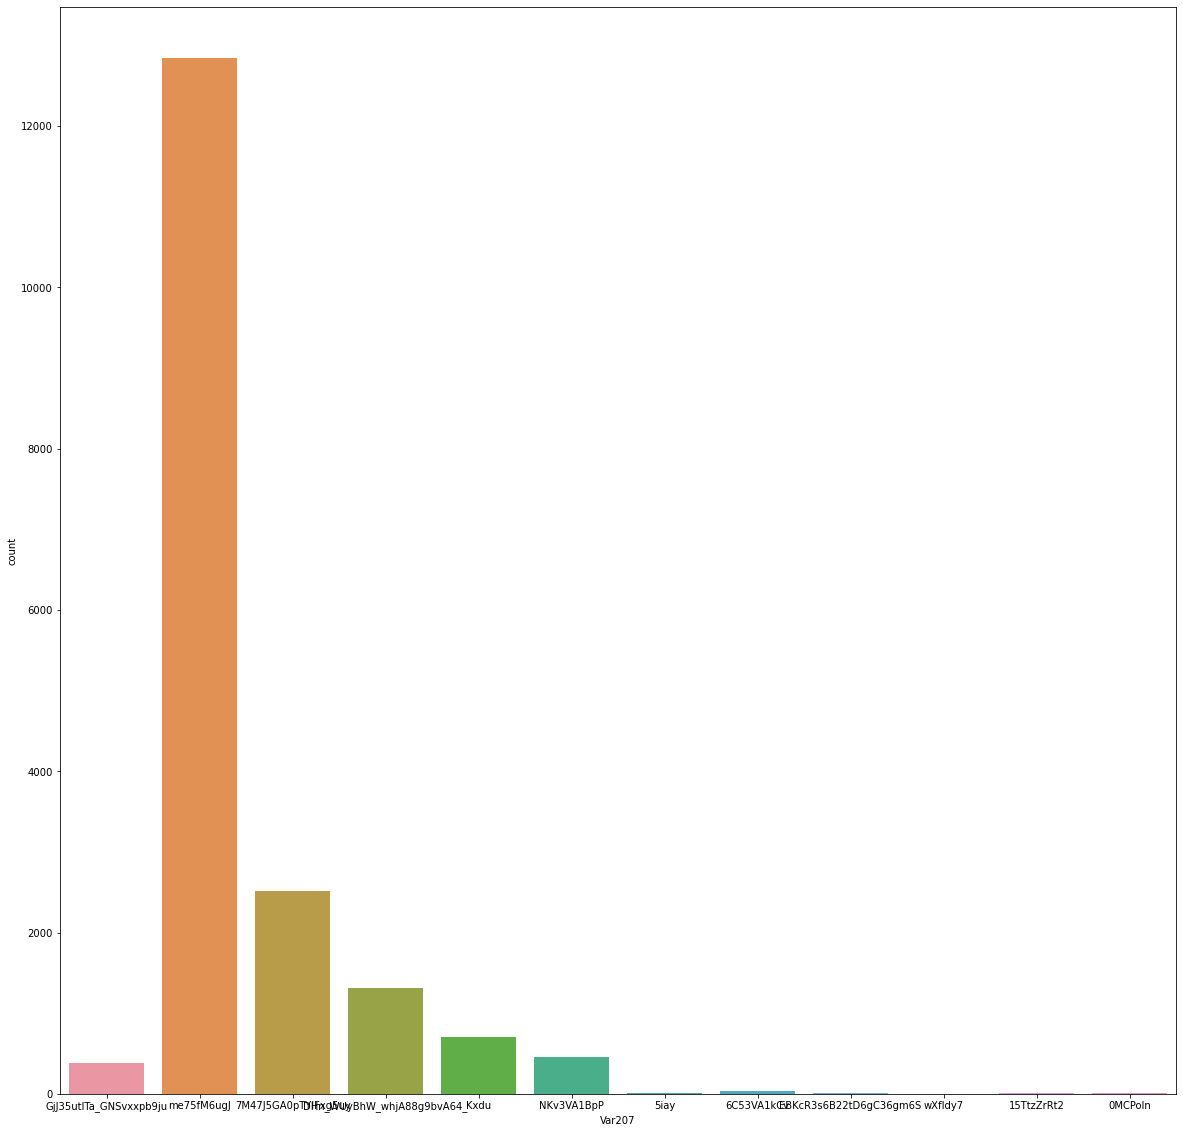

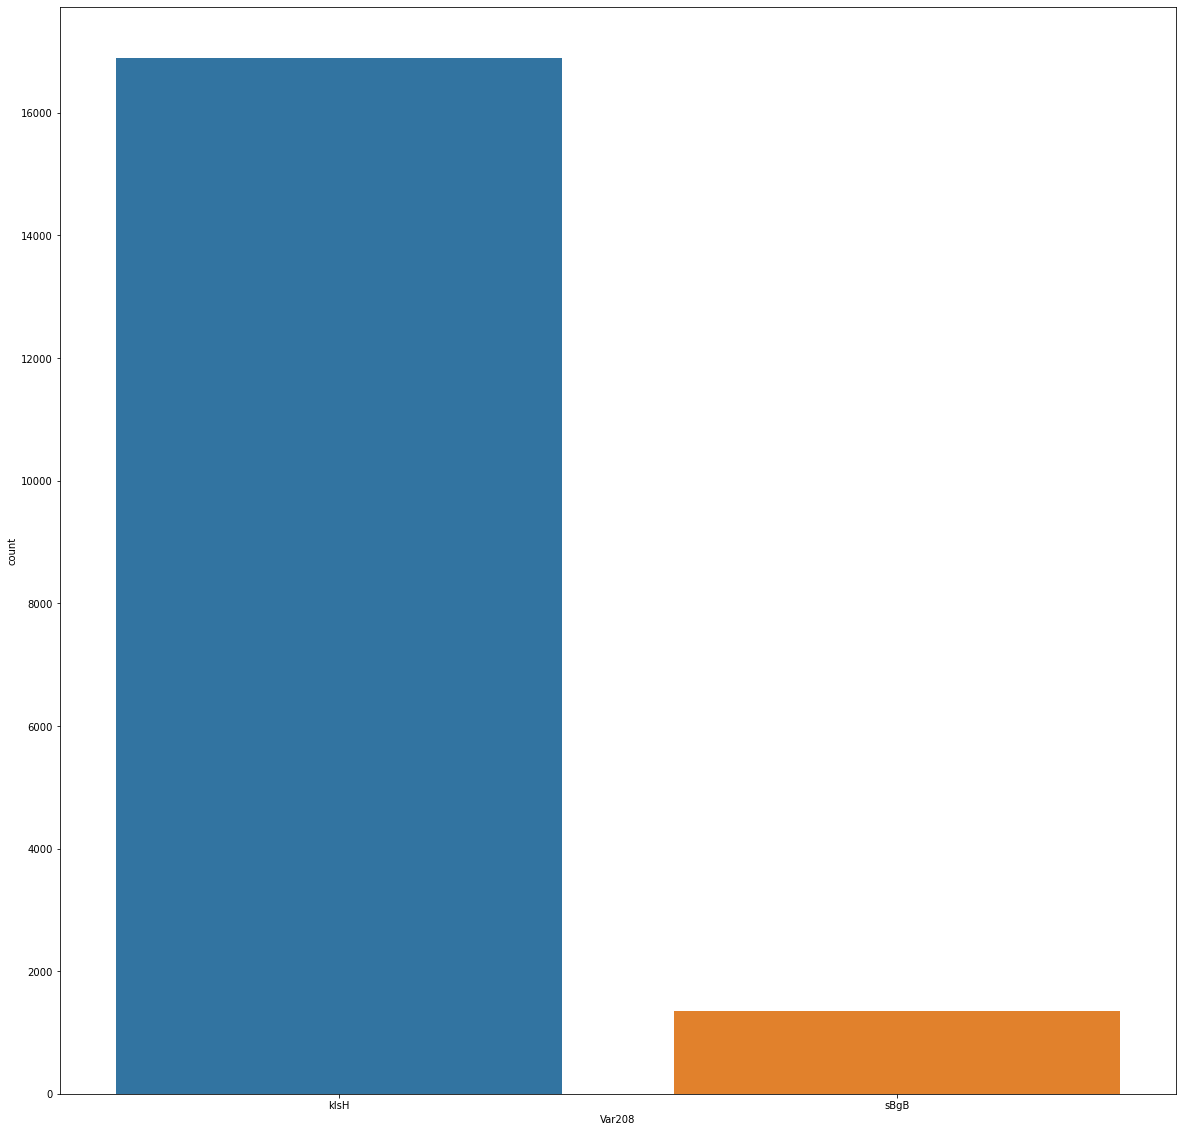

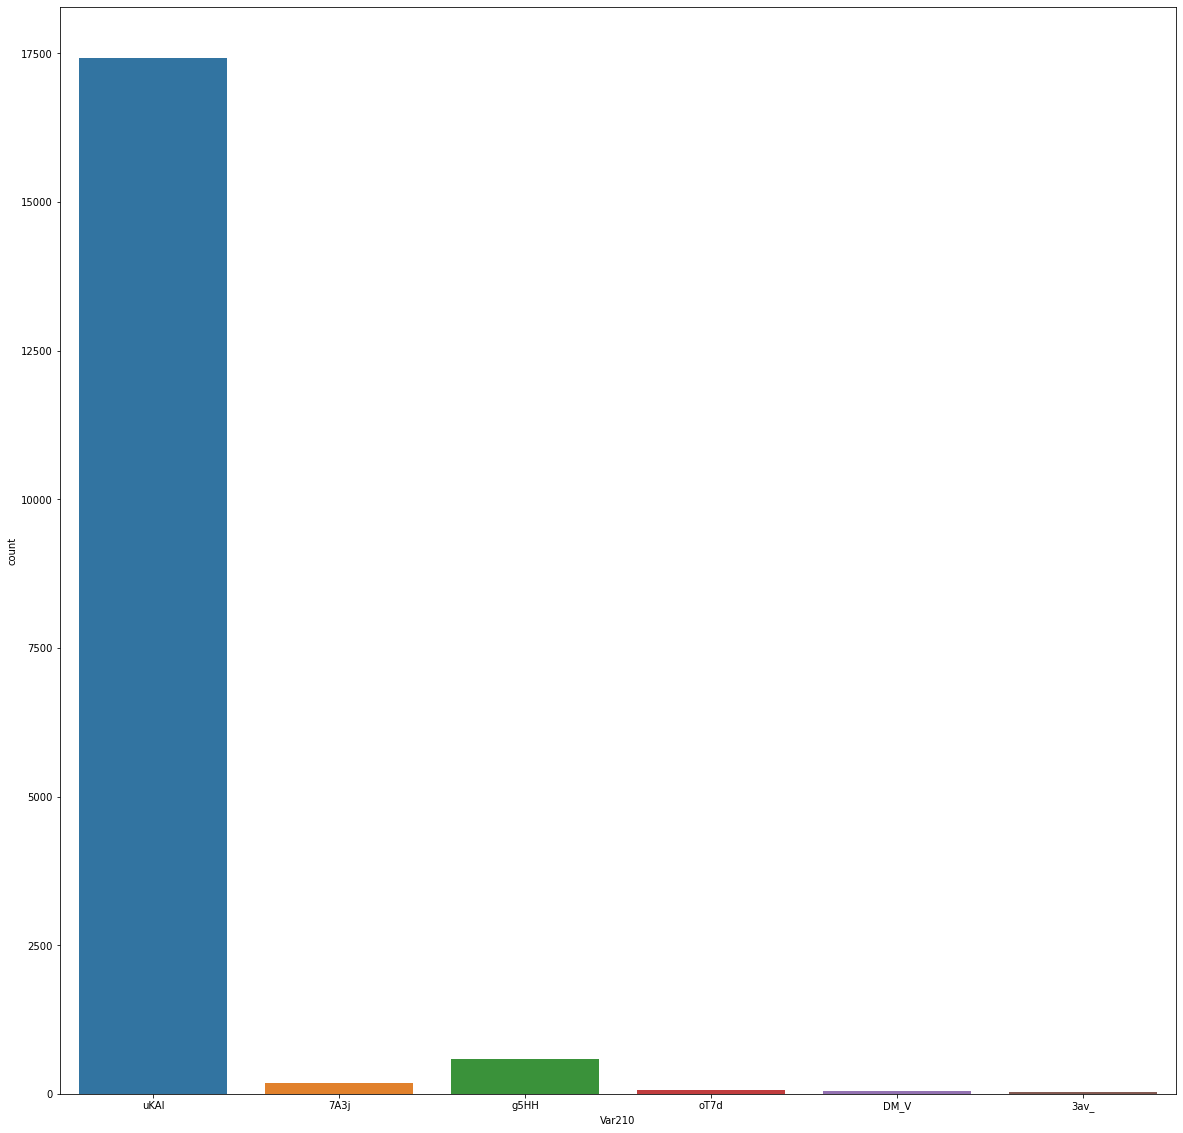

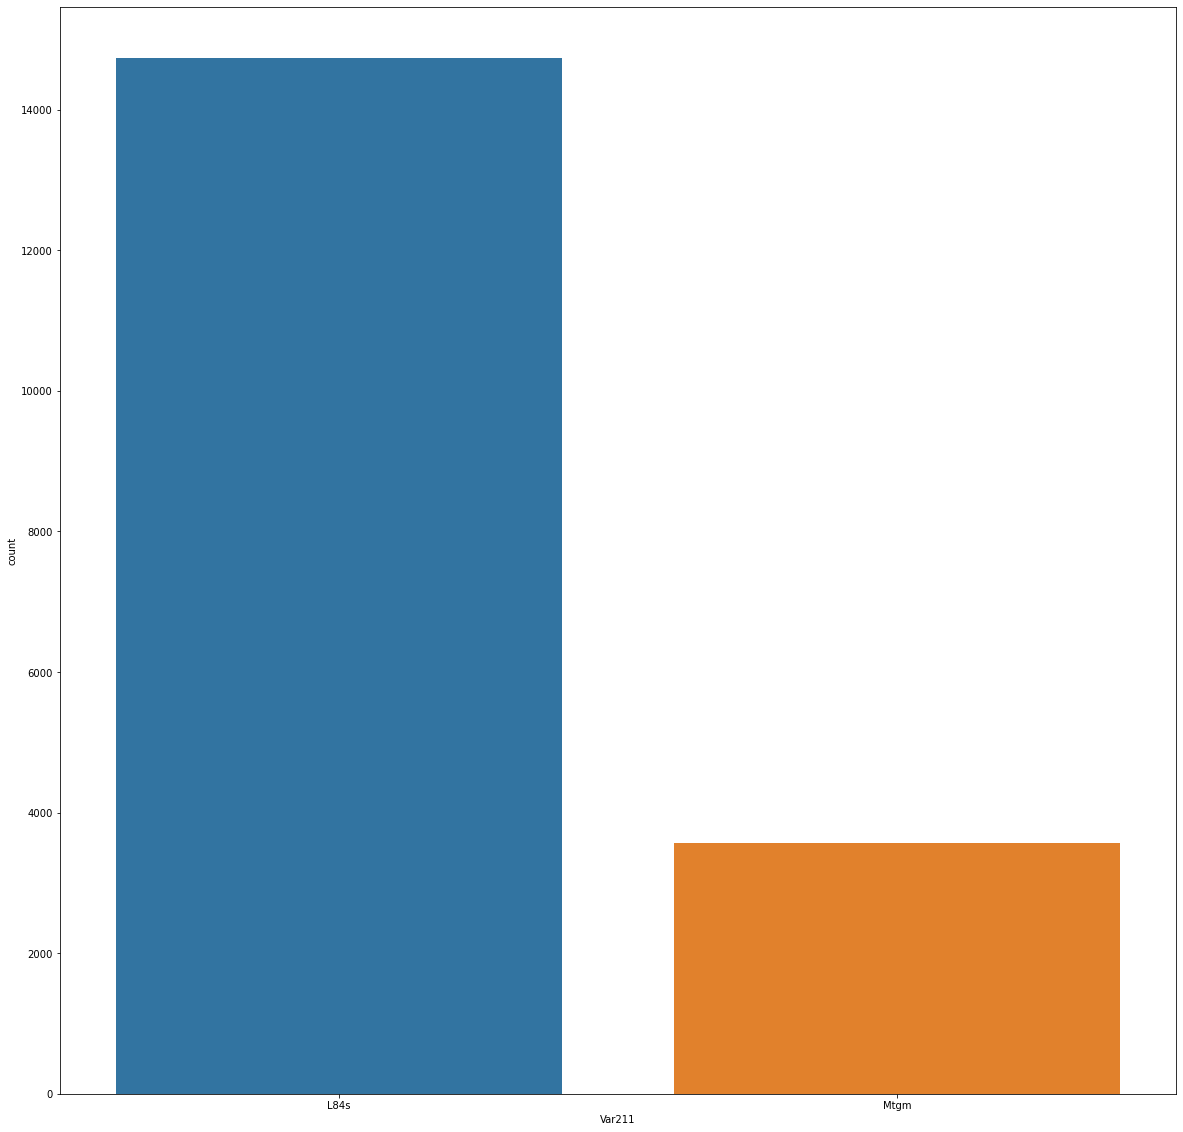

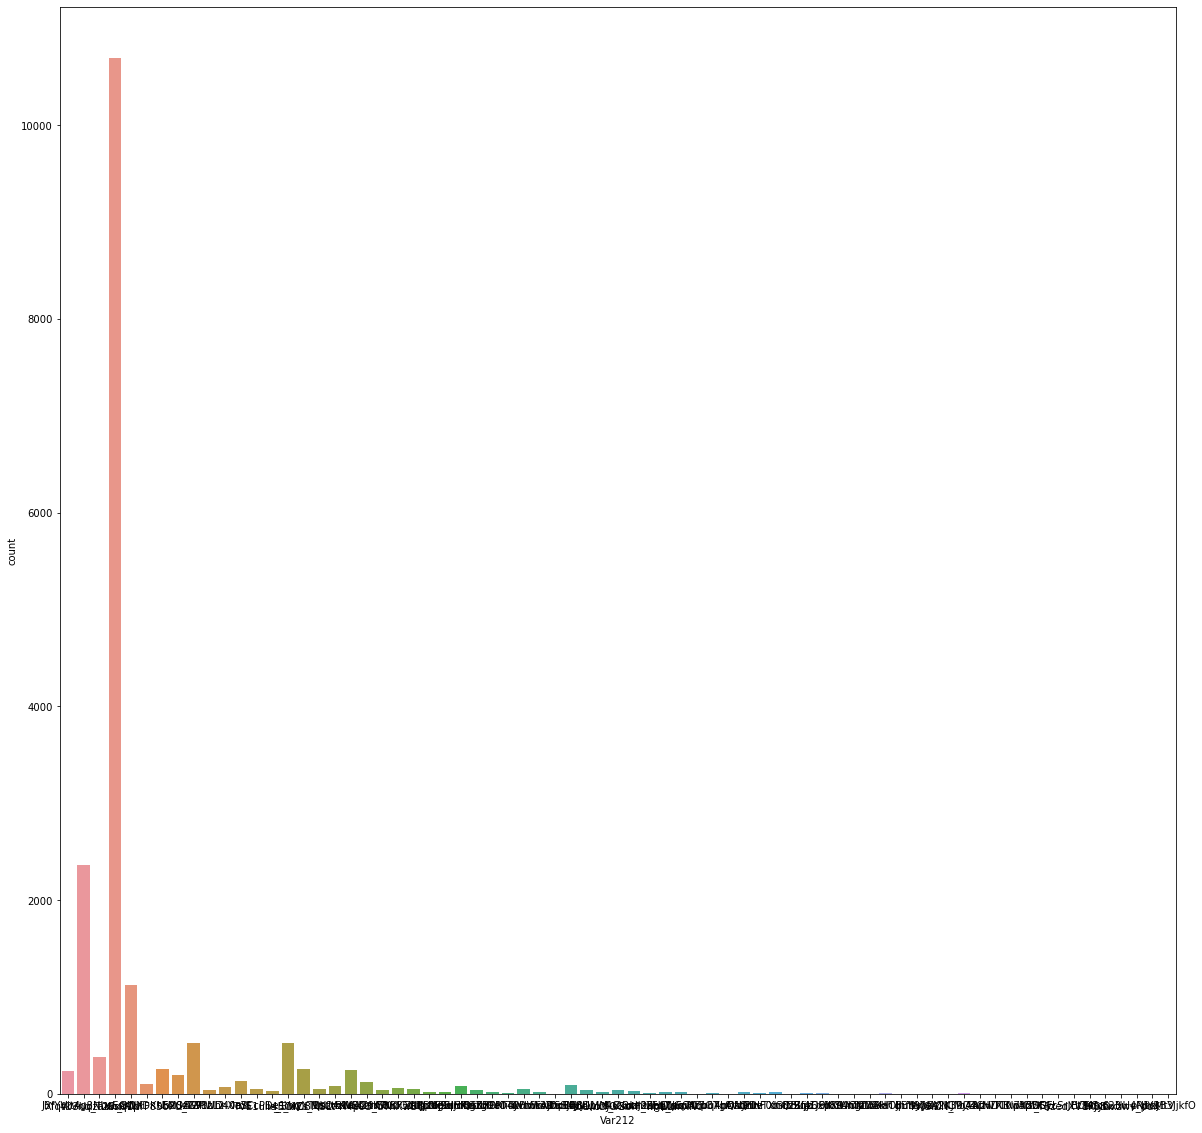

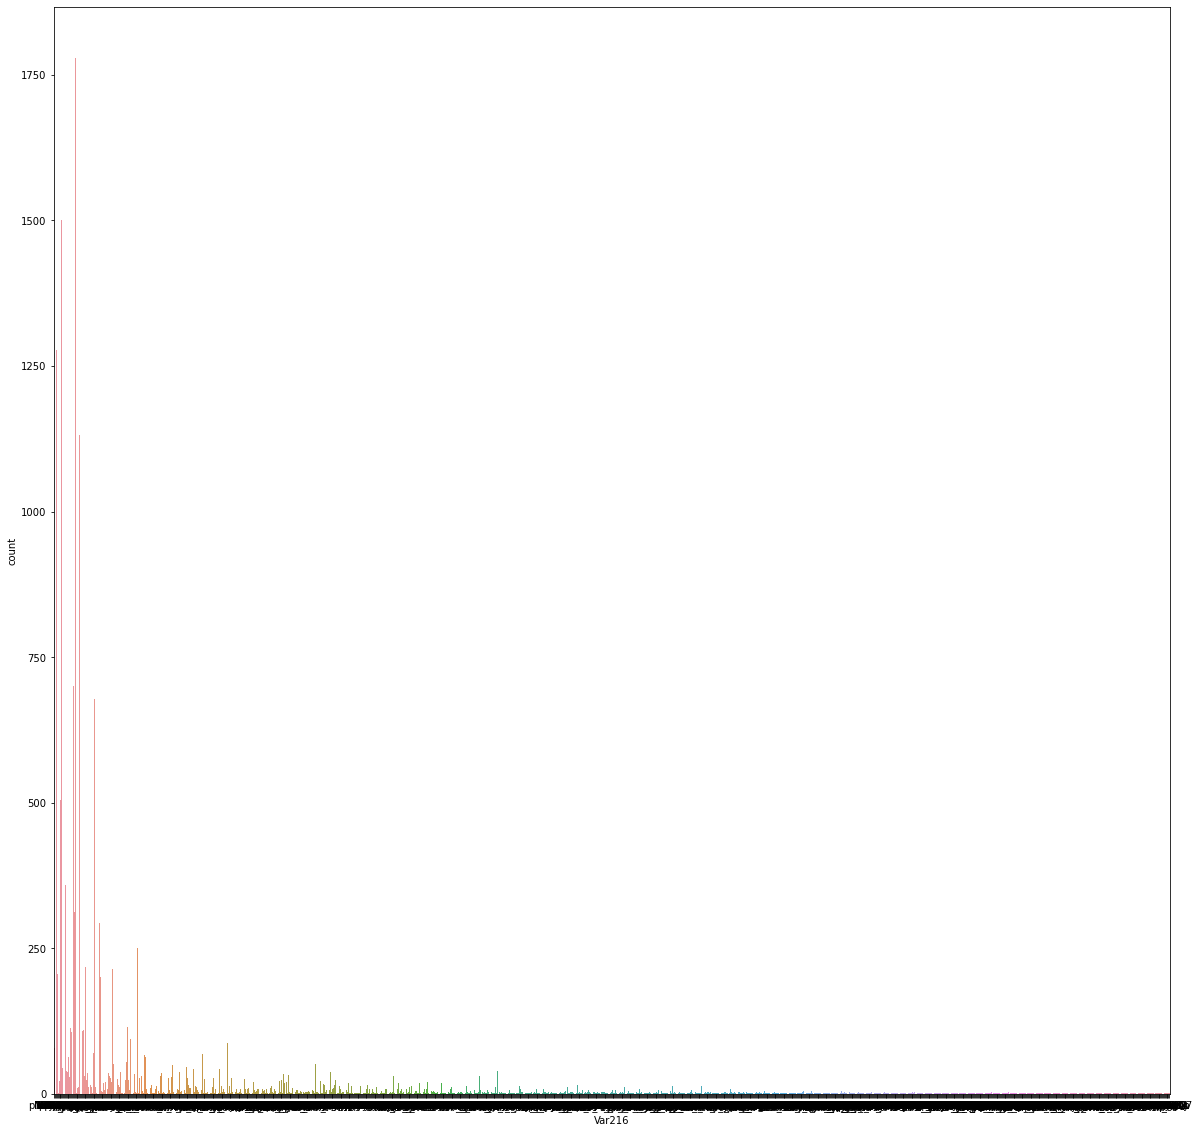

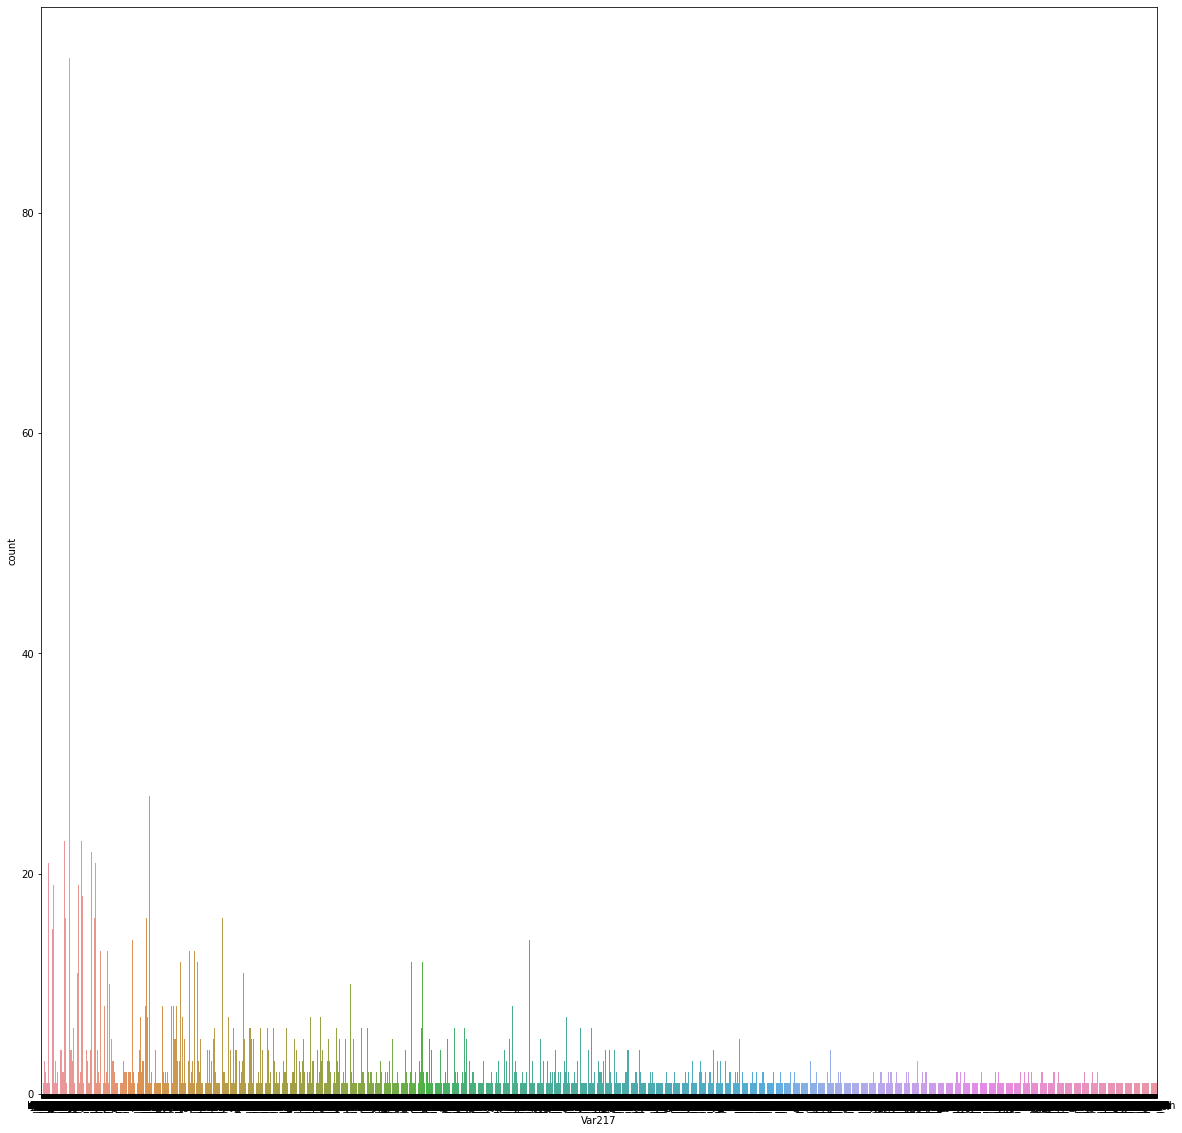

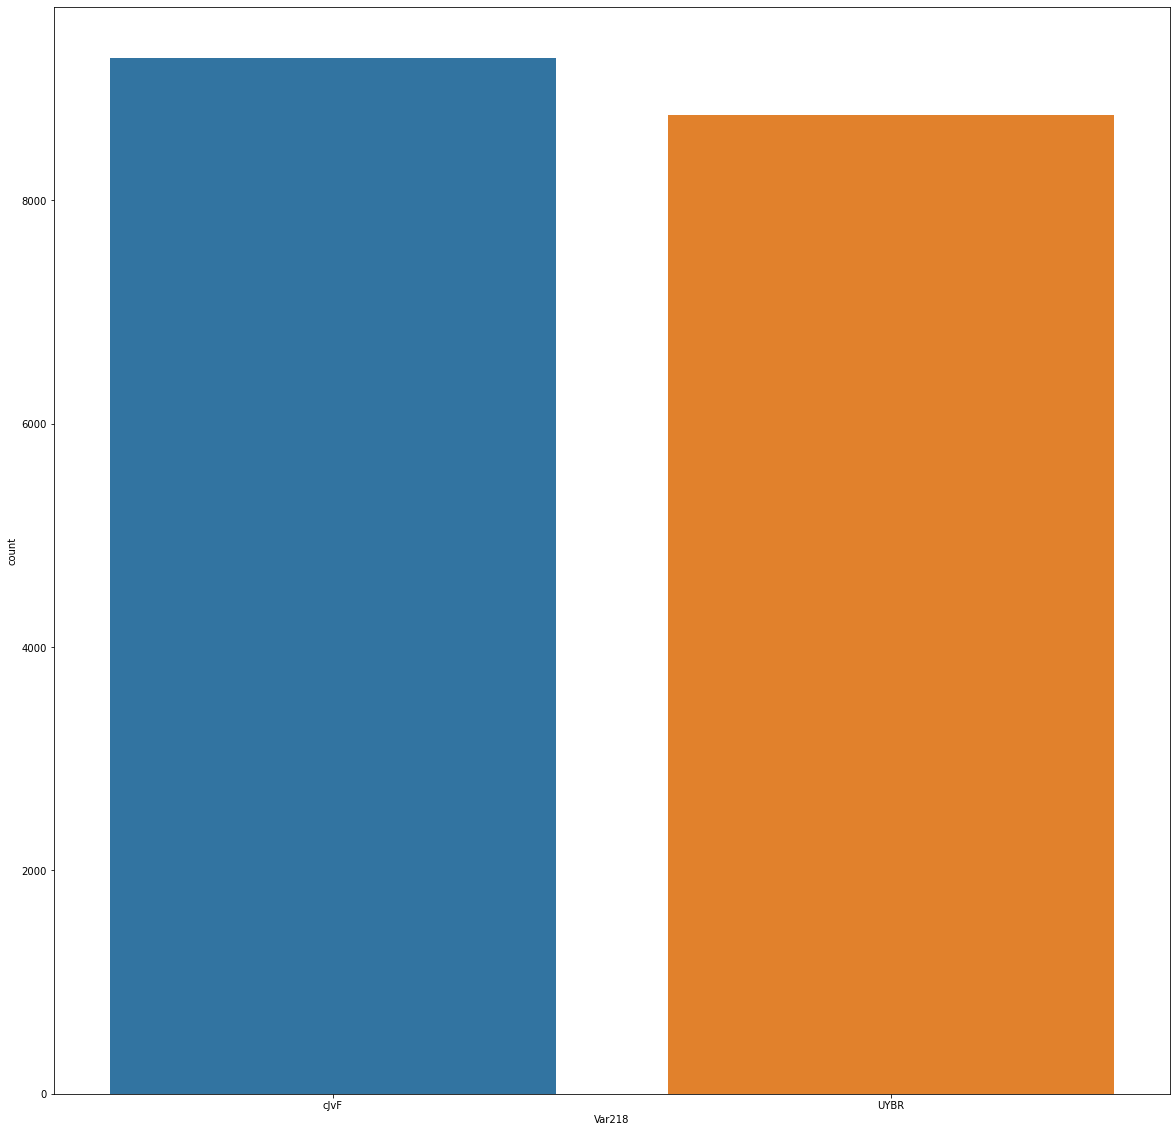

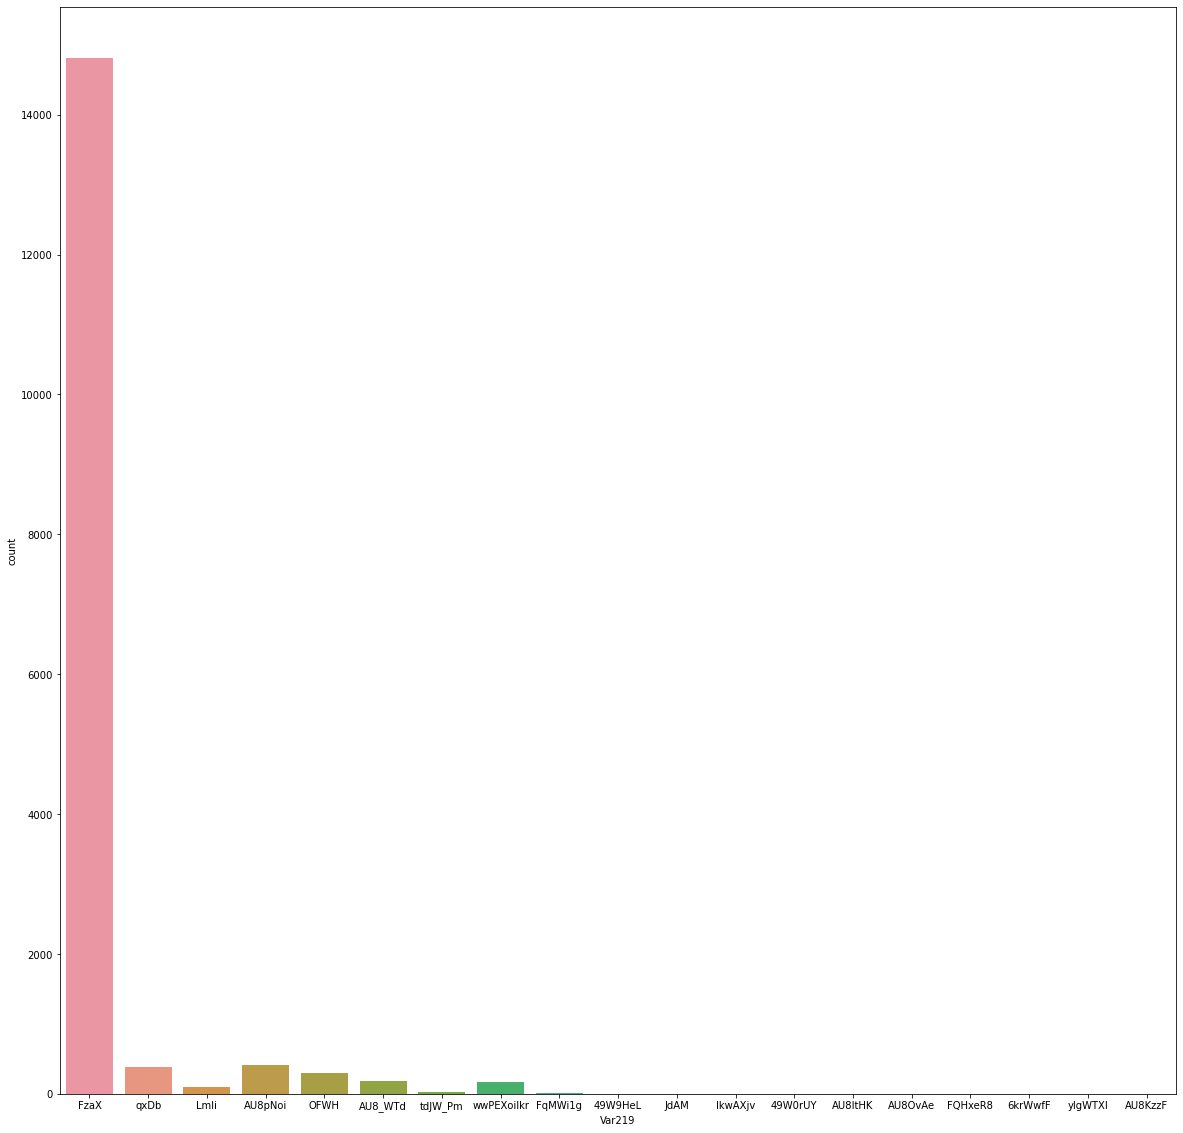

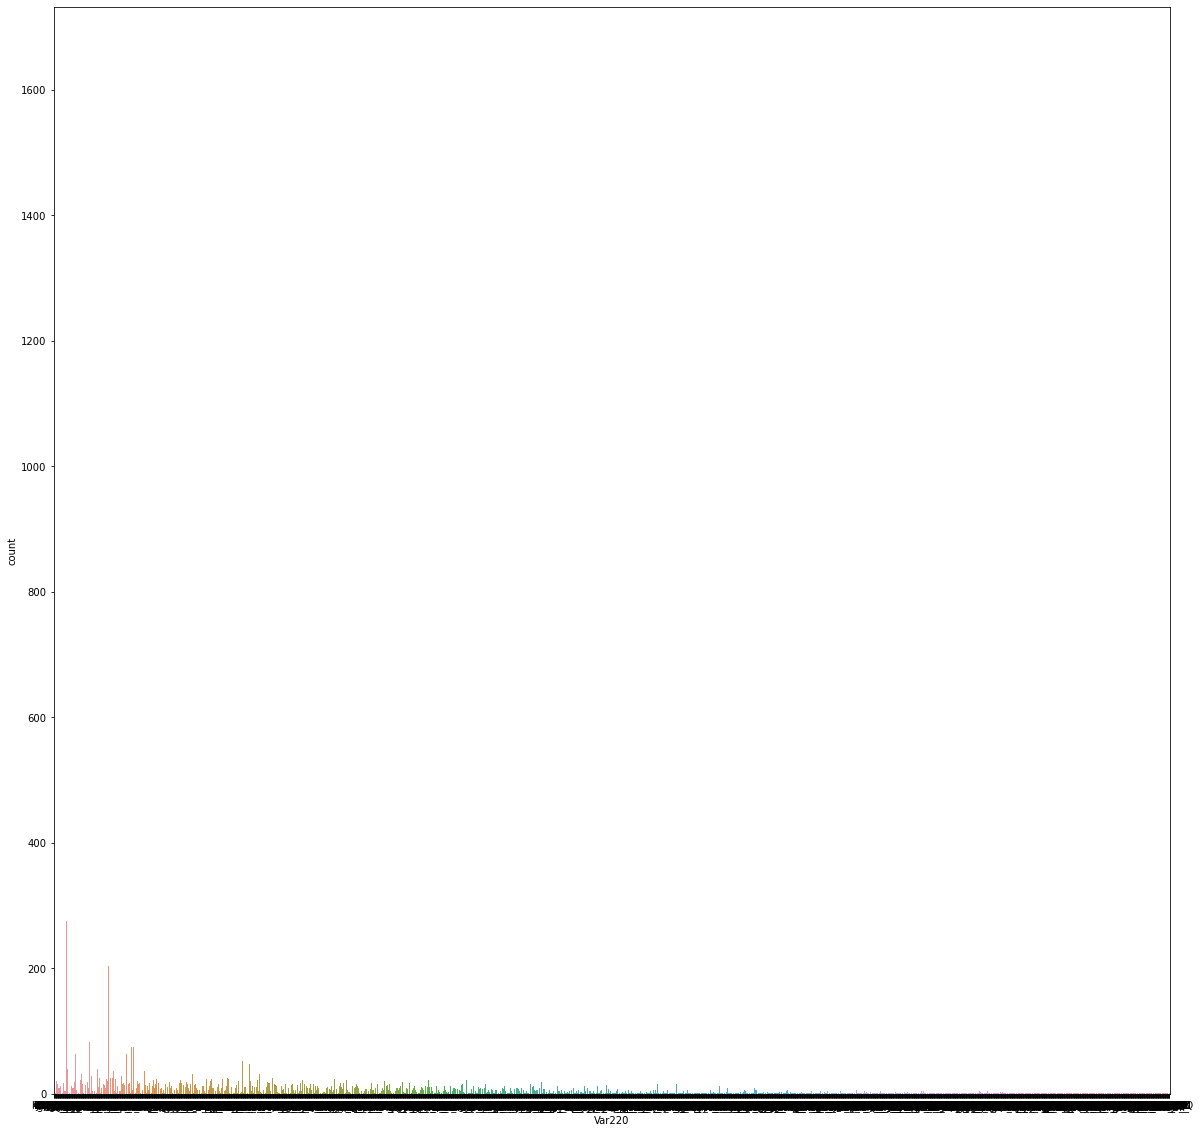

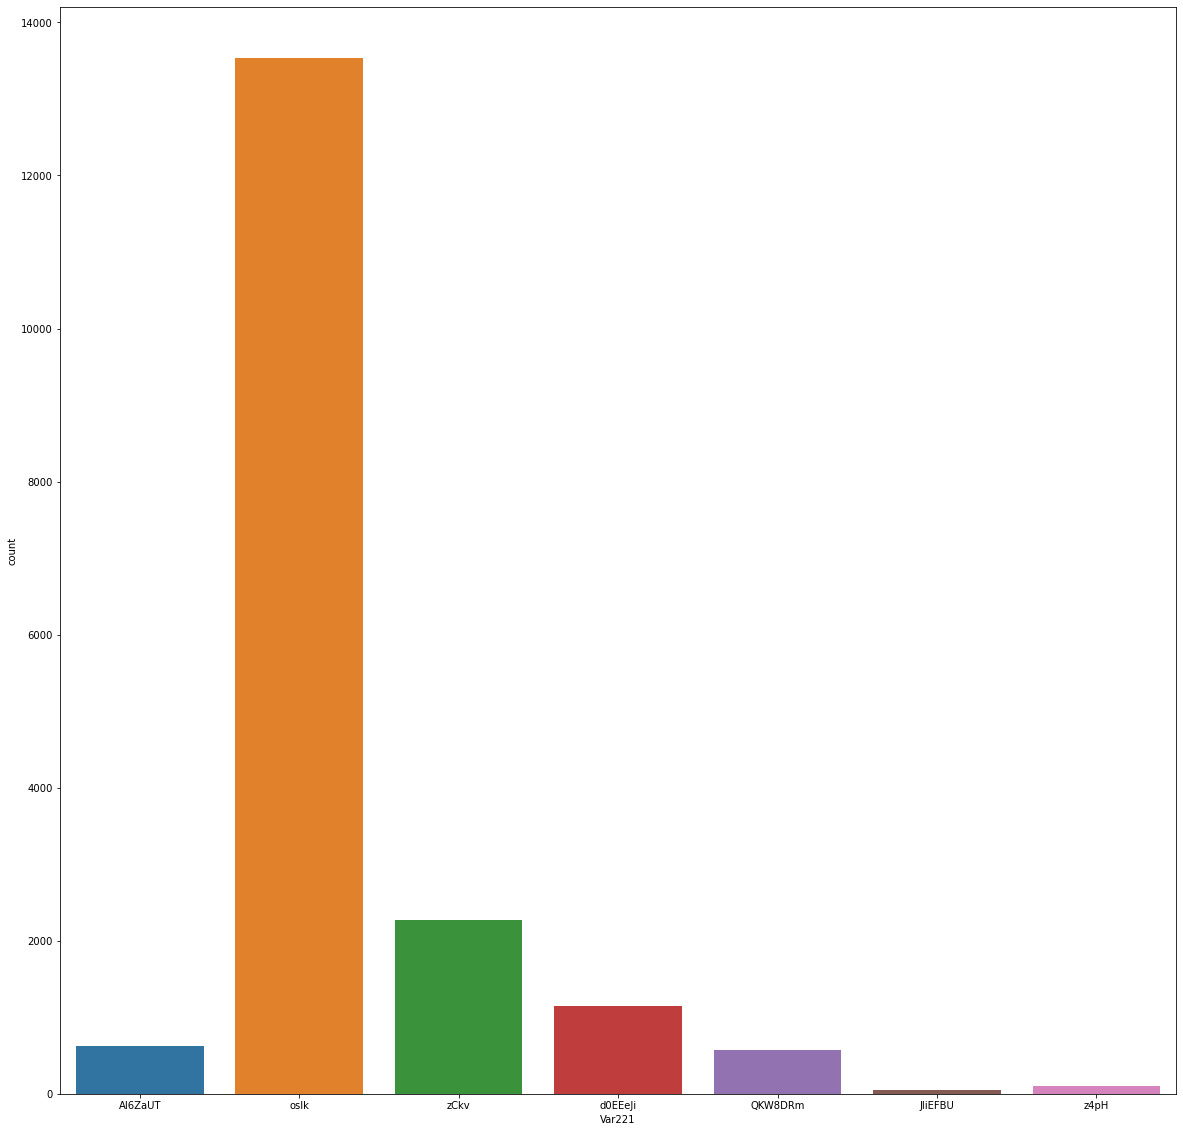

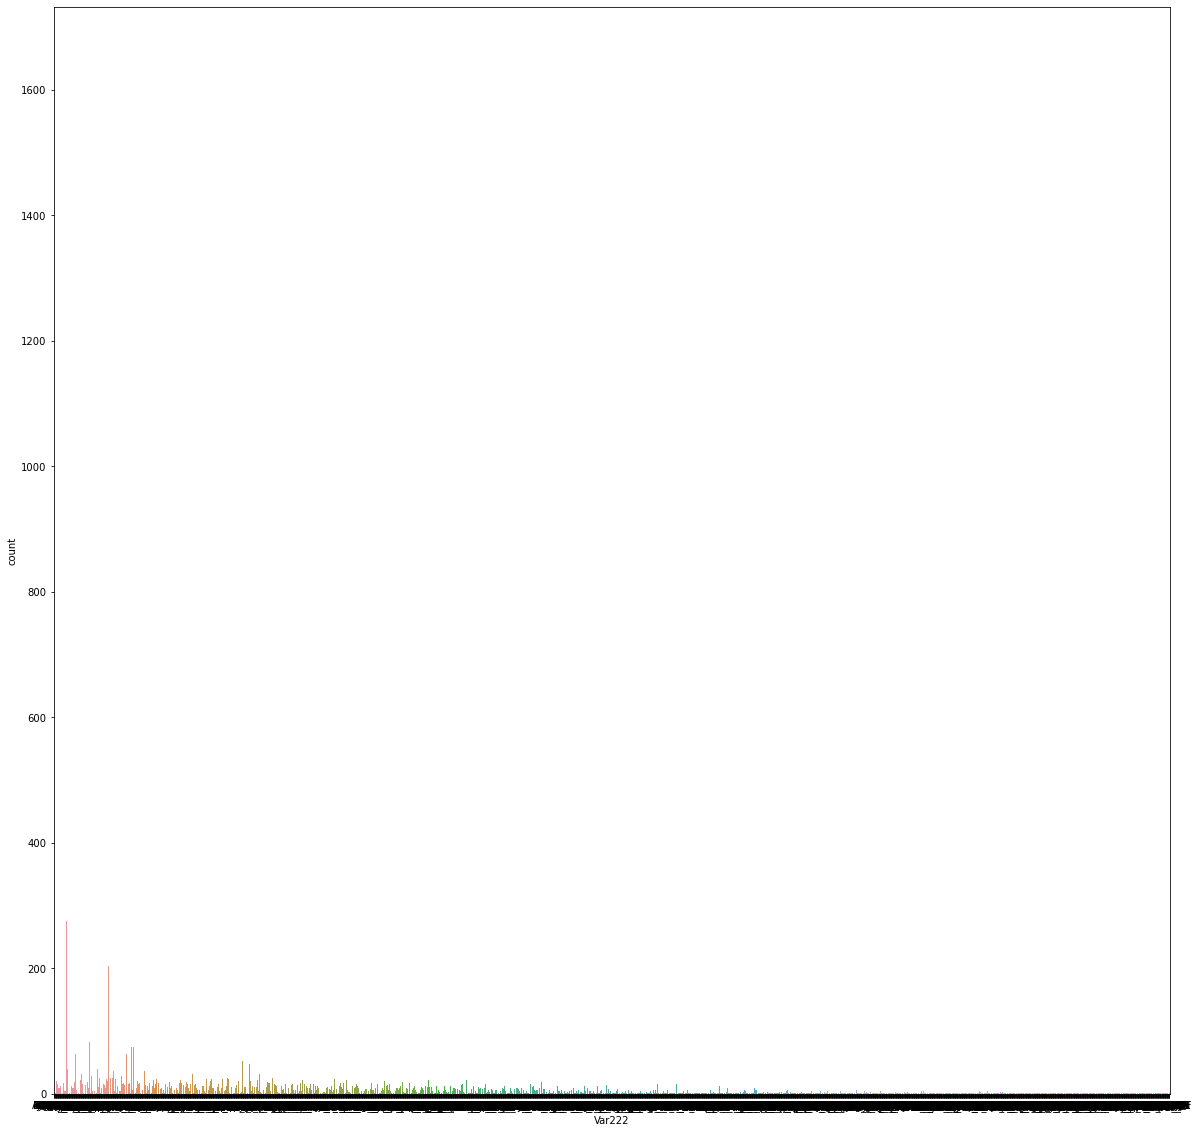

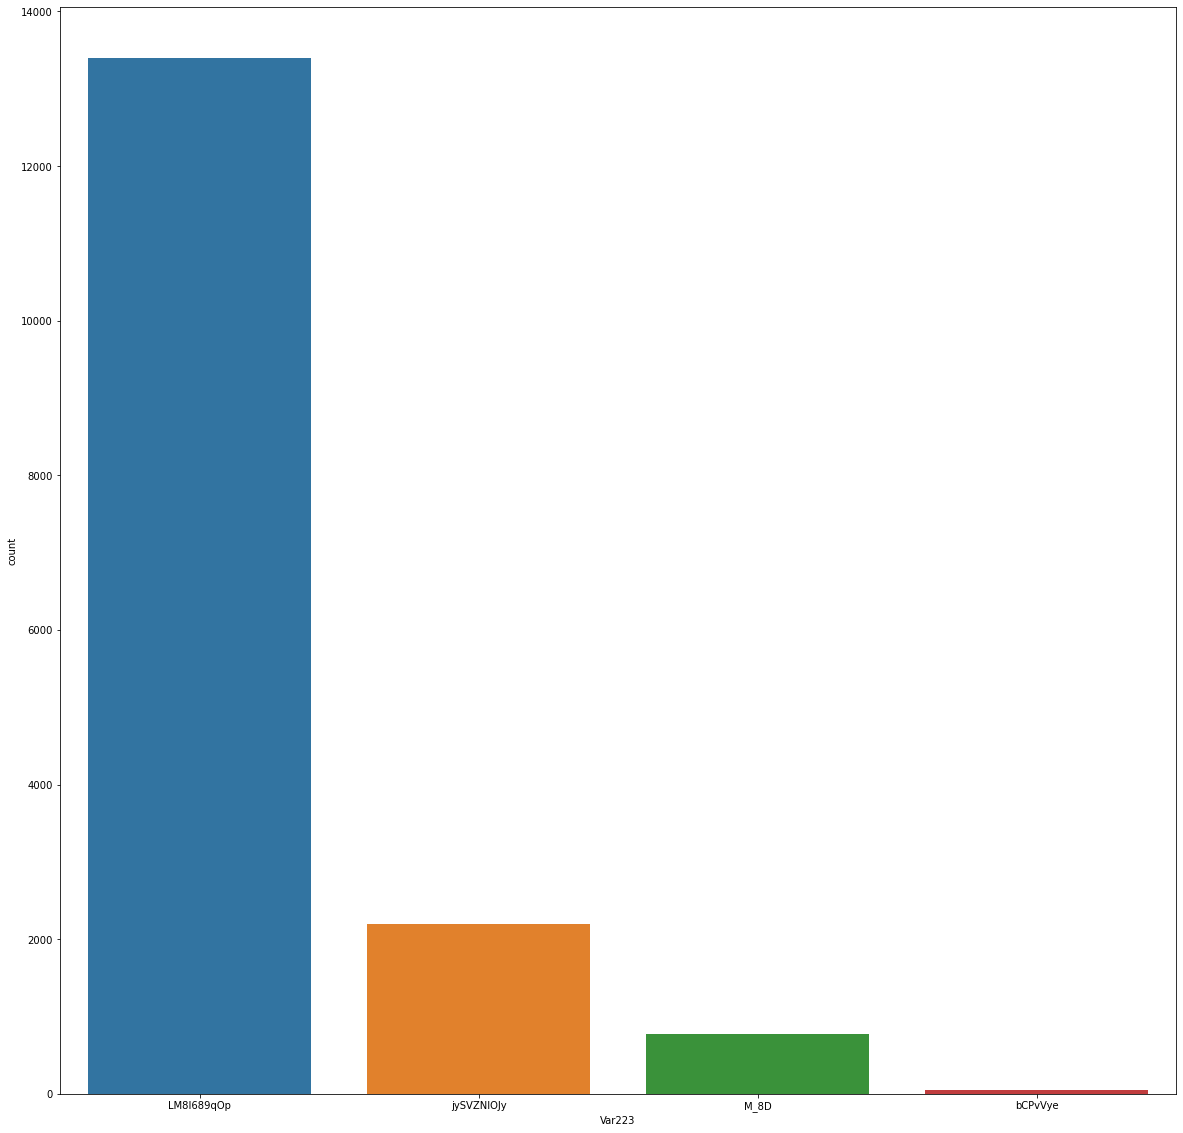

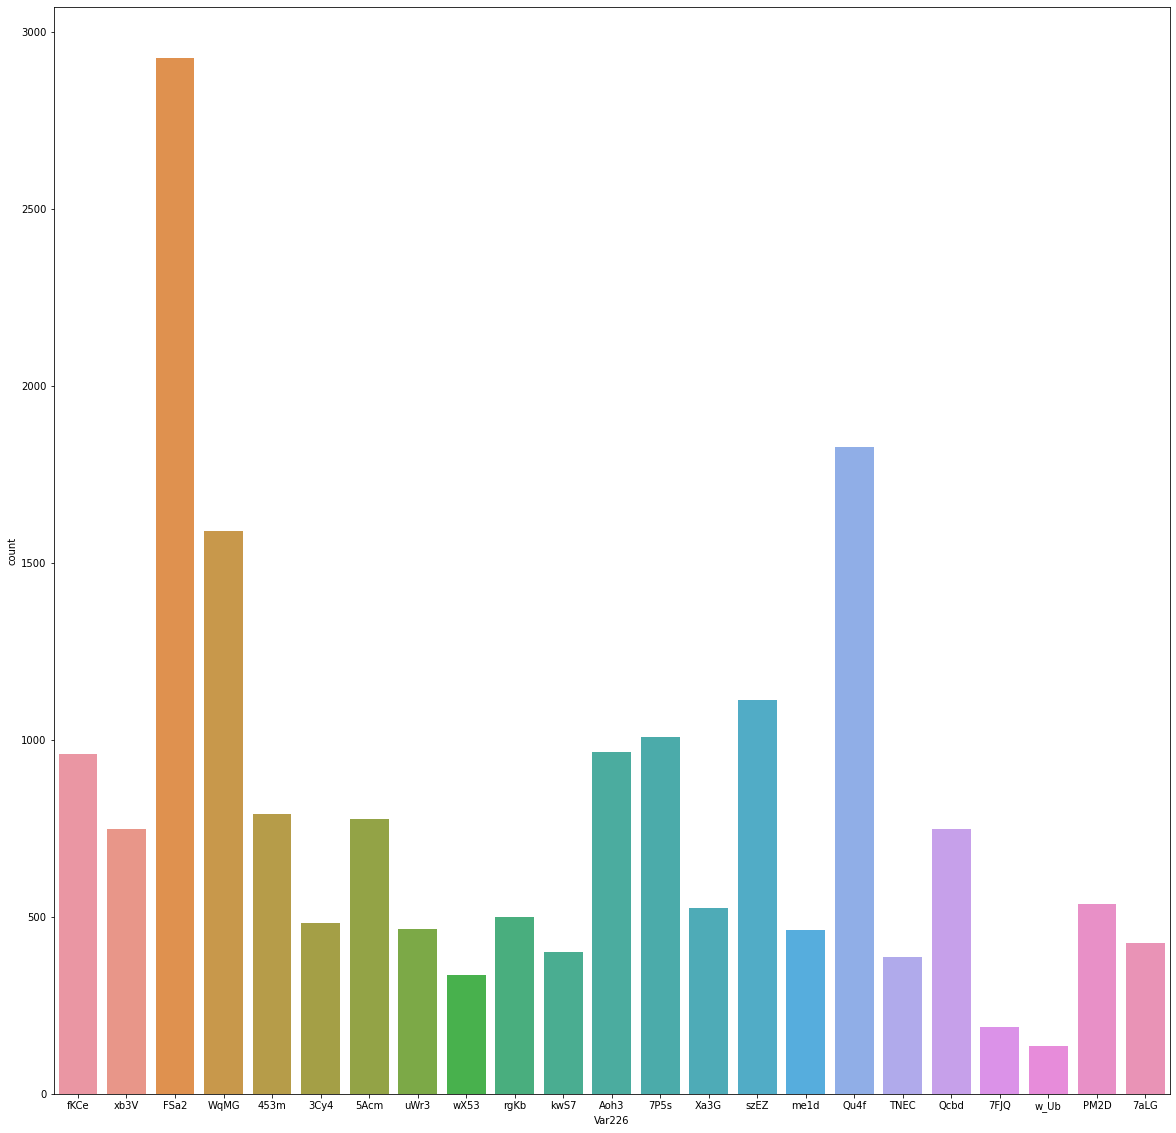

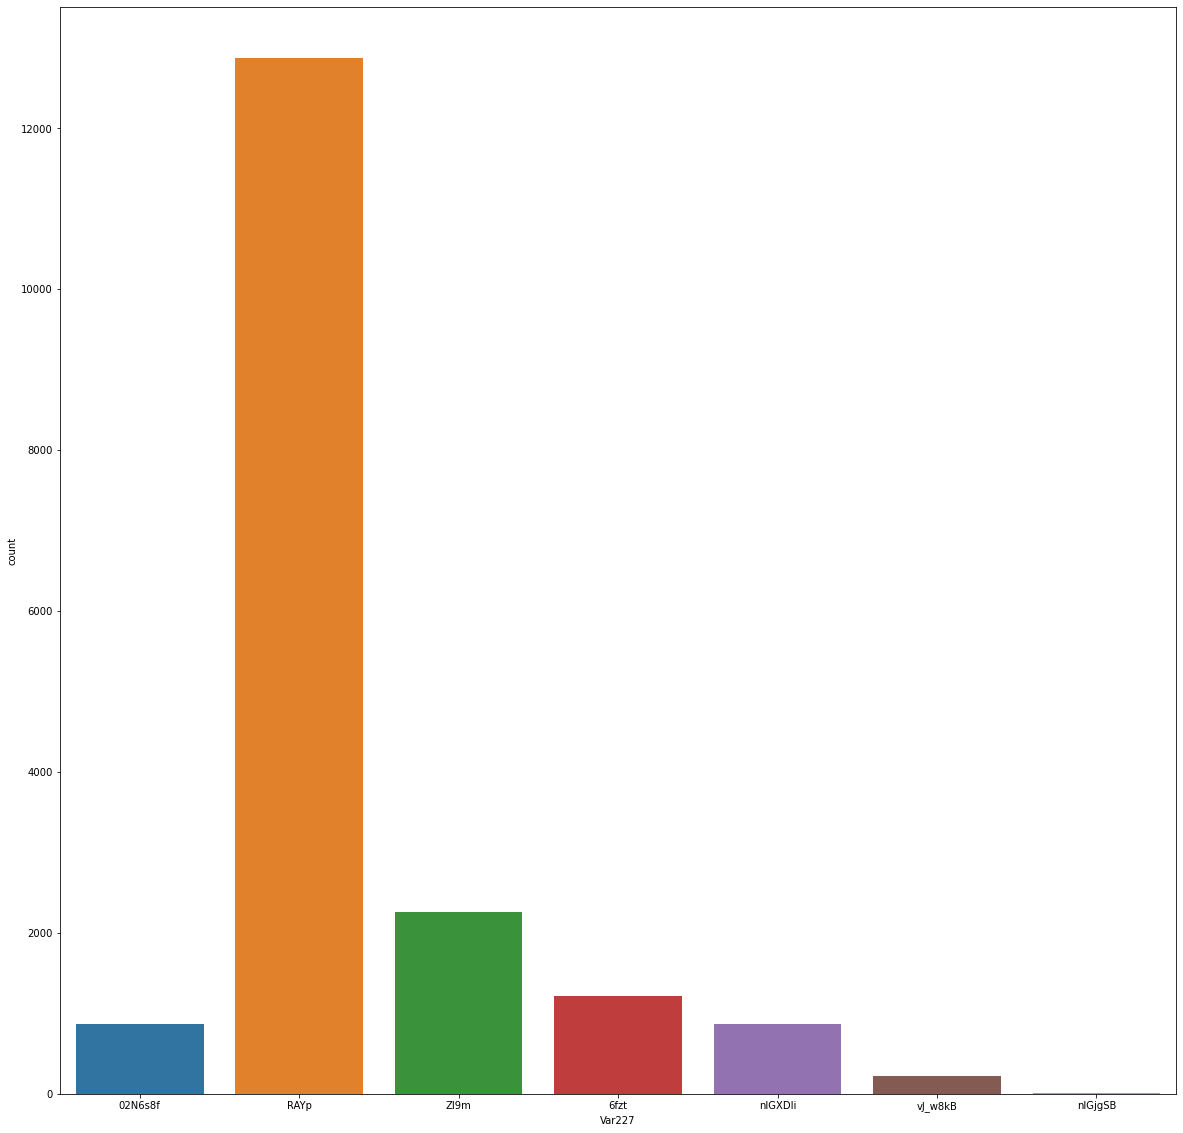

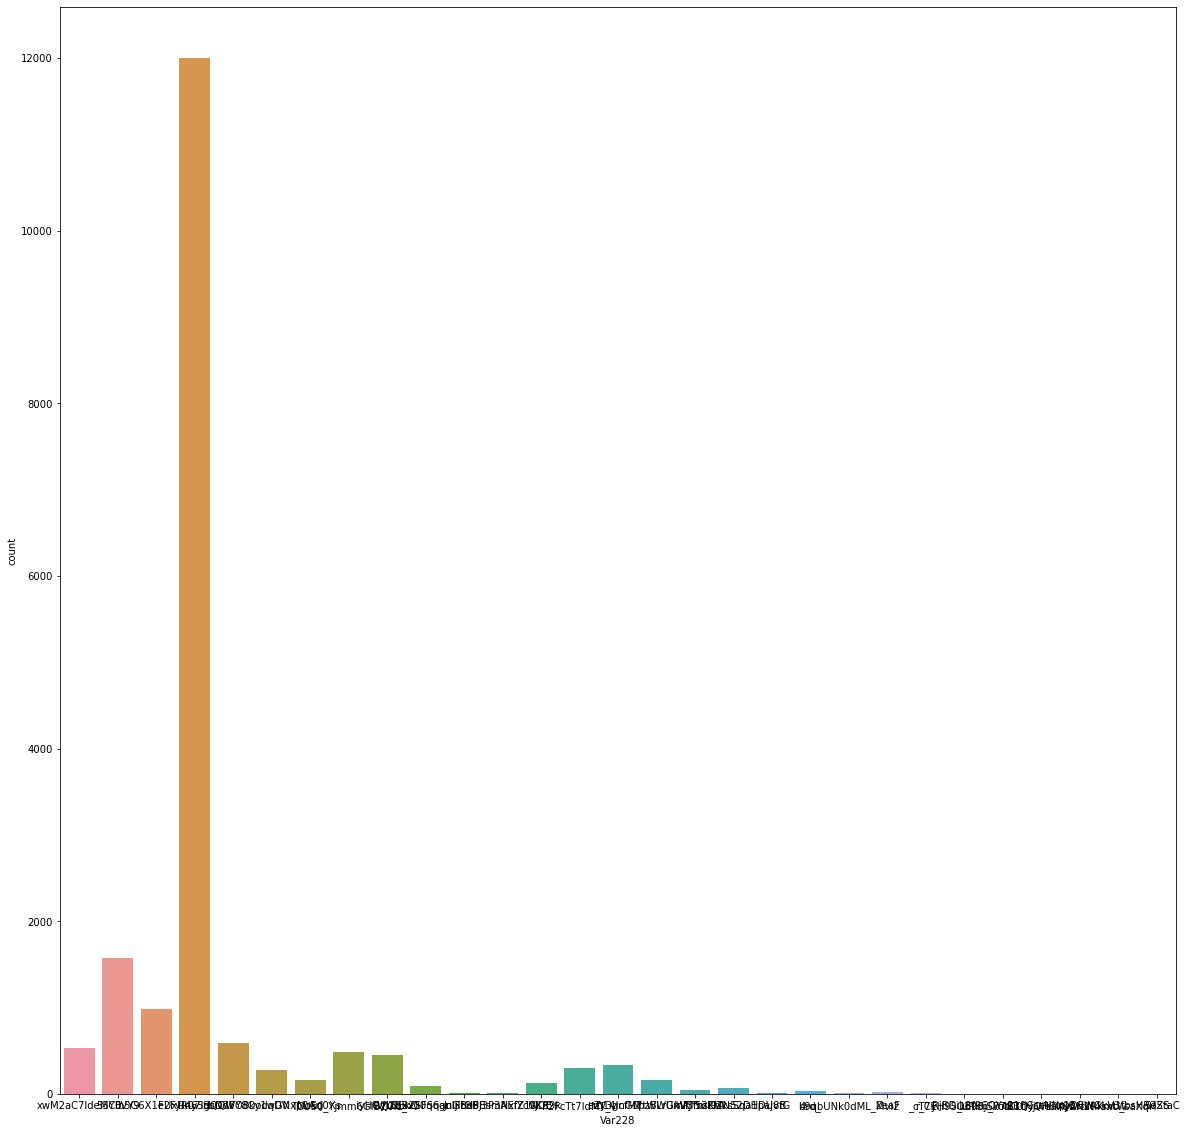

In [27]:
for name in right_cat_column:
    plt.figure(figsize=(20,20))
    sns.countplot(x=name, data=data[right_cat_column])

In [28]:
for check_name in ['Var196', 'Var195']:
    print(check_name)
    print(data[check_name].value_counts())
    

Var196
1K8T    18130
z3mO      159
JA1C        8
mKeq        1
Name: Var196, dtype: int64
Var195
taul                17562
LfvqpCtLOY            297
CiJDdr4TQ0rGERIS      203
ev6I                   70
CuXi4je                65
b_3Q                   24
I9xt3GDRhUK7p          24
I9xt3GMcxUnBZ          11
I9xt3GBDKUbd8           9
ArtjQZmIvr94p           6
ArtjQZ8ftr3NB           6
hiMqnEM7VgIk4JUu        4
lSbpiq1                 4
BNjsq81k1tWAYigY        3
bsZtYxFjzA              3
ZZBPiZh                 2
V10_0kx3ZF2we           1
ArtjQZQO1r9fC           1
CiJsoa4TQ0rGHlMp        1
F1JQrEL                 1
TnJpfvsJgF              1
Name: Var195, dtype: int64


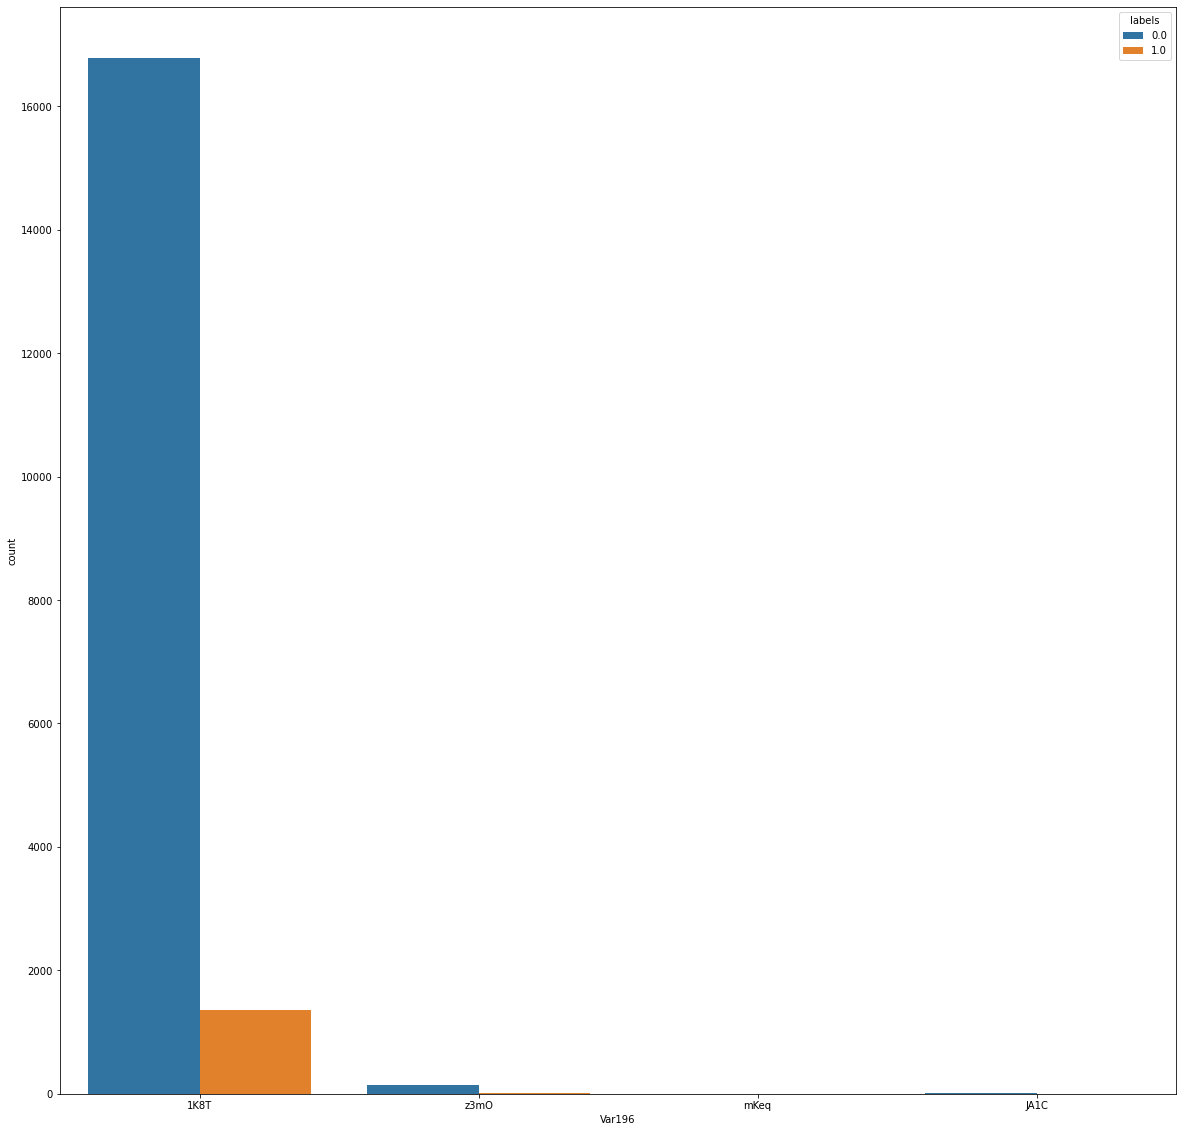

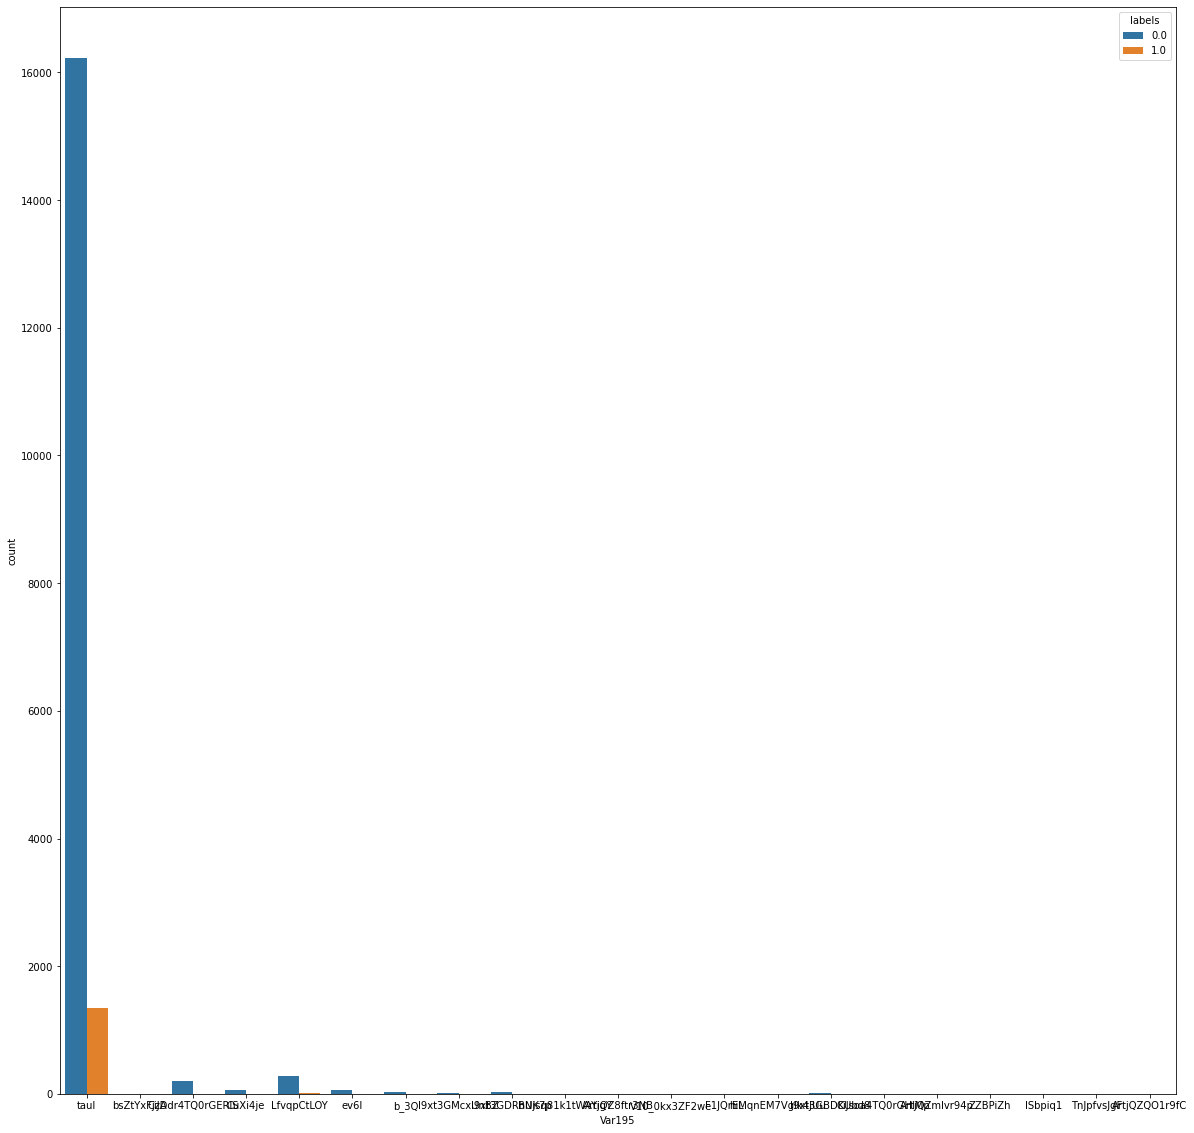

In [29]:
for check_name in ['Var196', 'Var195']:
    plt.figure(figsize=(20,20))
    sns.countplot(x=check_name, data=data[right_cat_column], hue = labels)

this feature is almost constant, it should drop from data

In [30]:
right_cat_column_1 = right_cat_column[~right_cat_column.isin(['Var196', 'Var195'])]

Correlation between feature and target

In [31]:
# Preprocessing cat features
cat_data = data[right_cat_column_1]
transform_cat_data = cat_data.copy()
dict_encoders = dict()
for name in cat_data.columns:
    unique_val = np.append(cat_data[name].unique(), 'unk_val')
    encoder_cur = LabelEncoder().fit(unique_val)
    dict_encoders[name] = encoder_cur
    transform_cat_data[name] = encoder_cur.transform(cat_data[name])

In [32]:
chi2_feature = chi2(transform_cat_data, labels)[0]

In [33]:
df_chi2 = pd.DataFrame({'features':transform_cat_data.columns,'chi2_feature':chi2_feature}).sort_values(by='chi2_feature',
                                                                                                        ascending=False)
df_chi2

,features,chi2_feature
16,Var217,17156.480064
19,Var220,5201.290431
4,Var199,1880.054984
15,Var216,1456.726191
5,Var202,797.036595
21,Var222,384.456945
3,Var198,226.581270
2,Var197,224.334905
1,Var193,124.619781
25,Var228,92.246172


In [34]:
right_cat_column_chi = df_chi2['features'][:14]

mutual info

In [35]:
mutual_info_class = mutual_info_classif(transform_cat_data, labels)

In [36]:
df_mutul_info = pd.DataFrame({'features':transform_cat_data.columns,
                              'mutual_feature':mutual_info_class}).sort_values(by='mutual_feature', ascending=False)
df_mutul_info

,features,mutual_feature
16,Var217,0.009318
15,Var216,0.008831
10,Var207,0.008033
4,Var199,0.007952
17,Var218,0.007424
12,Var210,0.006943
1,Var193,0.004737
18,Var219,0.004682
20,Var221,0.004649
5,Var202,0.003732


In [37]:
right_cat_column_mutual = df_mutul_info['features'][:15]

 binary classifier on one fetature

In [38]:
model_select = DecisionTreeClassifier(max_depth=20, random_state=42)
cv_strategy = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)


In [39]:
numeric_data = data[right_numeric_column]
mean_data = numeric_data.mean(axis='index')

for i, name in enumerate(right_numeric_column):
    numeric_data[name].fillna(mean_data[i], inplace=True)
    
scaler = StandardScaler().fit(numeric_data)
scaled_numeric_data = scaler.transform(numeric_data)

data_selecting_model = np.hstack((scaled_numeric_data, transform_cat_data))
columns = np.union1d(right_numeric_column, right_cat_column_1)

def selecting_feature_by_model(model, data, labels, columns, cv_strategy):
    feat_metric = []
    for i, name_column in enumerate(columns):
        data_train = data[:,i].reshape(-1,1)
        cv_metric = cross_val_score(model, data_train, labels, cv=cv_strategy, scoring='roc_auc')
        feat_metric.append(cv_metric.mean())
    
    df_info = pd.DataFrame({'features':columns,
                            'roc_feature':feat_metric}).sort_values(by='roc_feature', ascending=False)
    return df_info
    

In [40]:
df_model_select = selecting_feature_by_model(model_select, data_selecting_model, labels, columns, cv_strategy)

In [41]:
right_column_model = df_model_select['features'][:30]

iterative algo add drop

In [42]:
add_drop_selecting = SequentialFeatureSelector(model_select, n_features_to_select=30, scoring='roc_auc',
                                              cv=cv_strategy)

In [43]:
add_drop_selecting.fit(data_selecting_model, labels)

SequentialFeatureSelector(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=None),
                          estimator=DecisionTreeClassifier(max_depth=20,
                                                           random_state=42),
                          n_features_to_select=30, scoring='roc_auc')

In [44]:
right_column_iterative = columns[add_drop_selecting.get_support()]
right_column_iterative

array(['Var112', 'Var132', 'Var134', 'Var143', 'Var144', 'Var163',
       'Var173', 'Var193', 'Var197', 'Var205', 'Var206', 'Var210',
       'Var211', 'Var219', 'Var22', 'Var221', 'Var228', 'Var25', 'Var28',
       'Var35', 'Var38', 'Var44', 'Var57', 'Var6', 'Var72', 'Var73',
       'Var76', 'Var81', 'Var85', 'Var94'], dtype=object)

# Check different method for feature selection by cat boost with params set in use cat boost.ipynb

In [45]:
# different feature &  method selecting
# right_numeric_column - without nan
# right_cat_column - without nan
# right_columns_numeric_1 - withou corr between feature
# right_cat_column_1 - without almost constant cat feature
# right_cat_column_chi - select cat feature by chi2
# right_cat_column_mutual - select cat feature by mutual
# right_column_model - select num and cat based roc-auc model
# add_drop_selecting - methood ADD-DEL

In [46]:
best_params = {'depth': 4.0, 'l2_leaf_reg': 2.0, 'learning_rate': 0.286}
params = {
    'iterations':500,
    'eval_metric':'AUC',
    'loss_function':'Logloss',
    'random_seed':42,
    'verbose':False
}
params.update(best_params)

In [47]:
params

{'iterations': 500,
 'eval_metric': 'AUC',
 'loss_function': 'Logloss',
 'random_seed': 42,
 'verbose': False,
 'depth': 4.0,
 'l2_leaf_reg': 2.0,
 'learning_rate': 0.286}

In [48]:
model = CatBoostClassifier(**params)

In [49]:
dict_names = {
    'num_cat_without_nan' : np.union1d(right_numeric_column, right_cat_column),
    'num_without_corr_cat_without_corr' : np.union1d(right_columns_numeric_1, right_cat_column_1),
    'num_without_corr_cat_chi' : np.union1d(right_columns_numeric_1, right_cat_column_chi.to_numpy()),
    'num_without_corr_cat_mut' : np.union1d(right_columns_numeric_1, right_cat_column_mutual.to_numpy()),
    'column_by_metric_column' : right_column_model,
    'column_by_iterative': right_column_iterative
}

In [50]:
def find_optimal_feature(model, dict_names, init_cat_feature, data, label):
    dict_score_feature = dict()
    for name, columns in dict_names.items():
        filter_data = data[columns]
        filter_data.fillna('NaN', inplace=True)
        cat_columns = np.intersect1d(filter_data.columns, init_cat_feature)
        print(cat_columns)
        train_pool = Pool(filter_data, label, cat_features=cat_columns)
        cv_param = model.get_params()
        cv_data = cv(train_pool, cv_param, plot=False, verbose=False)
        best_metrics = np.max(cv_data['test-AUC-mean'])
        dict_score_feature[name] = best_metrics
        
    return dict_score_feature
        

In [51]:
dict_metrics_feature = find_optimal_feature(model, dict_names, right_cat_column, data, labels)

['Var192' 'Var193' 'Var195' 'Var196' 'Var197' 'Var198' 'Var199' 'Var202'
 'Var203' 'Var204' 'Var205' 'Var206' 'Var207' 'Var208' 'Var210' 'Var211'
 'Var212' 'Var216' 'Var217' 'Var218' 'Var219' 'Var220' 'Var221' 'Var222'
 'Var223' 'Var226' 'Var227' 'Var228']
Training on fold [0/3]

bestTest = 0.7257408508
bestIteration = 51

Training on fold [1/3]

bestTest = 0.7197812852
bestIteration = 95

Training on fold [2/3]

bestTest = 0.7363502217
bestIteration = 43

['Var192' 'Var193' 'Var197' 'Var198' 'Var199' 'Var202' 'Var203' 'Var204'
 'Var205' 'Var206' 'Var207' 'Var208' 'Var210' 'Var211' 'Var212' 'Var216'
 'Var217' 'Var218' 'Var219' 'Var220' 'Var221' 'Var222' 'Var223' 'Var226'
 'Var227' 'Var228']
Training on fold [0/3]

bestTest = 0.723824829
bestIteration = 46

Training on fold [1/3]

bestTest = 0.7163418007
bestIteration = 138

Training on fold [2/3]

bestTest = 0.7257014942
bestIteration = 35

['Var193' 'Var197' 'Var198' 'Var199' 'Var202' 'Var205' 'Var206' 'Var207'
 'Var211' 'Var216' 'Var

In [52]:
dict_metrics_feature

{'num_cat_without_nan': 0.7247787101294435,
 'num_without_corr_cat_without_corr': 0.7185995033066904,
 'num_without_corr_cat_chi': 0.7170268169015325,
 'num_without_corr_cat_mut': 0.7211210151468431,
 'column_by_metric_column': 0.6507850253117712,
 'column_by_iterative': 0.6424307473954214}

check selecting feature based on cat boost

In [61]:
data_check = data[np.union1d(right_numeric_column, right_cat_column)]
data_check.fillna('NaN', inplace=True)
pool =  Pool(data_check, labels, cat_features=list(right_cat_column))
model_fitted = model.fit(pool, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [79]:
feature_importances = model_fitted.get_feature_importance(pool)
feature_names = data_check.columns
dict_impotant = dict(sorted(zip(feature_names, feature_importances), reverse=True, key = lambda x:x[1]))
dict_impotant

{'Var126': 13.978064135245722,
 'Var113': 4.343846403154301,
 'Var57': 4.177404739374742,
 'Var199': 3.7524520022302044,
 'Var73': 2.741101236375236,
 'Var192': 2.729593269548551,
 'Var202': 2.68455361325503,
 'Var222': 2.635042144678702,
 'Var133': 2.5580599536668536,
 'Var74': 2.500757910652786,
 'Var226': 2.48342097019684,
 'Var216': 2.359244896926522,
 'Var81': 2.1675988553219865,
 'Var134': 2.154028293341742,
 'Var204': 2.1513422564688414,
 'Var13': 2.143406433025957,
 'Var205': 2.1374099682041496,
 'Var6': 1.958548108474739,
 'Var38': 1.9570958827125302,
 'Var160': 1.890141868521243,
 'Var153': 1.796570939672022,
 'Var217': 1.7860513417947776,
 'Var218': 1.7494398815550425,
 'Var28': 1.6972949675016091,
 'Var207': 1.6043320681074893,
 'Var149': 1.4073169051190089,
 'Var119': 1.3837284975481765,
 'Var123': 1.3531385204161193,
 'Var140': 1.3376447982140875,
 'Var206': 1.3364239149768278,
 'Var125': 1.3178638499574127,
 'Var210': 1.2254748959629582,
 'Var193': 1.2131796142267883,
 '

In [80]:
cat_boost_feature = list(dict_impotant.keys())[:30]
cat_boost_feature

['Var126',
 'Var113',
 'Var57',
 'Var199',
 'Var73',
 'Var192',
 'Var202',
 'Var222',
 'Var133',
 'Var74',
 'Var226',
 'Var216',
 'Var81',
 'Var134',
 'Var204',
 'Var13',
 'Var205',
 'Var6',
 'Var38',
 'Var160',
 'Var153',
 'Var217',
 'Var218',
 'Var28',
 'Var207',
 'Var149',
 'Var119',
 'Var123',
 'Var140',
 'Var206']

check quality selected features

In [82]:
data_check_q = data[cat_boost_feature]
data_check_q.fillna('NaN', inplace=True)
pool =  Pool(data_check_q, labels, cat_features=np.intersect1d(list(right_cat_column), cat_boost_feature))
cv_param = model.get_params()
cv_data = cv(pool, cv_param, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.7319210928
bestIteration = 66

Training on fold [1/3]

bestTest = 0.7239384879
bestIteration = 58

Training on fold [2/3]

bestTest = 0.7295071772
bestIteration = 49



Check coreletion new feature and dist